In [1]:
import torch
from torch import optim
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import splitext
from glob import glob
from PIL import Image
from tqdm import tqdm
import logging
from unet_model import UNet

In [2]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
class TheDataset(Dataset):
    def __init__(self, interlaced_dir, gtruth_dir, scale=1):
        self.interlaced_dir = interlaced_dir
        self.gtruth_dir = gtruth_dir
        self.scale = scale
        self.transform = transforms.Compose([transforms.RandomCrop(256), transforms.ToTensor()])
        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(interlaced_dir)]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        pil_img = pil_img
        
        return pil_img

    def __getitem__(self, i):
        idx = self.ids[i]
        gtruth_file = glob(self.gtruth_dir + idx + '.*')
        interlaced_file = glob(self.interlaced_dir + idx + '.*')

        assert len(gtruth_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {gtruth_file}'
        assert len(interlaced_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {interlaced_file}'
        gtruth = Image.open(gtruth_file[0])
        interlaced = Image.open(interlaced_file[0])

        assert interlaced.size == gtruth.size, \
            f'Image and mask {idx} should be the same size, but are {interlaced.size} and {gtruth.size}'
        
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        interlaced = self.transform(interlaced)
        interlaced = self.preprocess(interlaced, self.scale)
        
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        gtruth = self.transform(gtruth)
        gtruth = self.preprocess(gtruth, self.scale)

        return interlaced, gtruth
    

In [4]:
interlaced_dir = "./dataset/interlaced/"
gtruth_dir = "./dataset/ground_truth/"
img_scale = 1

In [5]:
def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=1):

    dataset = TheDataset(interlaced_dir, gtruth_dir, img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)
    for inter, truth in tqdm(train_loader):
        print(np.array(inter[0].permute(1,2,0)))
        imshow(np.array(inter[0].permute(1,2,0)))
        imshow(np.array(truth[0].permute(1,2,0)))
        break

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-8)
    criterion = MSELoss()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        net.train()
        epoch_loss = 0
        
        for batch, (interlaced, truths) in enumerate(tqdm(train_loader)):
            interlaced = interlaced.to(device=device, dtype=torch.float32)
            truths = truths.to(device=device, dtype=torch.float32)
            
            net_pred = net(interlaced)
            loss = criterion(net_pred, truths)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % 10 == 0:
                loss, current = loss.item(), batch * len(interlaced)
                print(f"loss: {loss}  [{current}/{n_train}]")
            

  0%|                                                                                         | 0/6067 [00:00<?, ?it/s]

[[[0.6431373  0.5411765  0.4862745 ]
  [0.6392157  0.5372549  0.48235294]
  [0.6392157  0.5411765  0.4745098 ]
  ...
  [0.99215686 0.9411765  0.9137255 ]
  [0.9882353  0.94509804 0.9254902 ]
  [0.99215686 0.9490196  0.92941177]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.6431373  0.5411765  0.4862745 ]
  [0.6392157  0.5372549  0.48235294]
  [0.6392157  0.5411765  0.4745098 ]
  ...
  [0.8156863  0.74509805 0.7254902 ]
  [0.8039216  0.73333335 0.7137255 ]
  [0.7882353  0.7176471  0.69803923]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.31764707 0.31764707 0.2       ]
  [0.31764707 0.31764707 0.2       ]


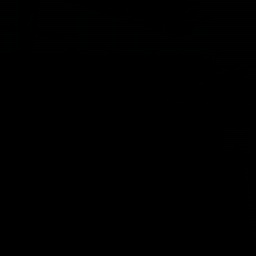

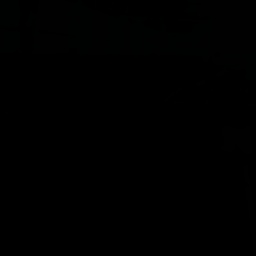

  0%|                                                                                         | 0/6067 [00:00<?, ?it/s]

Epoch 1
-------------------------------


  0%|                                                                              | 1/6067 [00:06<10:43:55,  6.37s/it]

loss: 0.8388891816139221  [0/84930]


  0%|▏                                                                             | 11/6067 [00:49<7:26:15,  4.42s/it]

loss: 0.06311455368995667  [140/84930]


  0%|▎                                                                             | 21/6067 [01:32<7:20:16,  4.37s/it]

loss: 0.012231659144163132  [280/84930]


  1%|▍                                                                             | 31/6067 [02:15<7:21:33,  4.39s/it]

loss: 0.008032013662159443  [420/84930]


  1%|▌                                                                             | 41/6067 [02:58<7:20:29,  4.39s/it]

loss: 0.005334856919944286  [560/84930]


  1%|▋                                                                             | 51/6067 [03:41<7:22:21,  4.41s/it]

loss: 0.004385336302220821  [700/84930]


  1%|▊                                                                             | 61/6067 [04:24<7:18:18,  4.38s/it]

loss: 0.004515128675848246  [840/84930]


  1%|▉                                                                             | 71/6067 [05:07<7:19:42,  4.40s/it]

loss: 0.003307342529296875  [980/84930]


  1%|█                                                                             | 81/6067 [05:50<7:21:20,  4.42s/it]

loss: 0.009872526861727238  [1120/84930]


  1%|█▏                                                                            | 91/6067 [06:33<7:16:55,  4.39s/it]

loss: 0.004614551085978746  [1260/84930]


  2%|█▎                                                                           | 101/6067 [07:18<7:20:18,  4.43s/it]

loss: 0.003464402863755822  [1400/84930]


  2%|█▍                                                                           | 111/6067 [08:01<7:15:42,  4.39s/it]

loss: 0.003360565286129713  [1540/84930]


  2%|█▌                                                                           | 121/6067 [08:44<7:18:31,  4.43s/it]

loss: 0.0017245032358914614  [1680/84930]


  2%|█▋                                                                           | 131/6067 [09:27<7:17:48,  4.43s/it]

loss: 0.005772130098193884  [1820/84930]


  2%|█▊                                                                           | 141/6067 [10:11<7:17:49,  4.43s/it]

loss: 0.0022721390705555677  [1960/84930]


  2%|█▉                                                                           | 151/6067 [10:55<7:22:48,  4.49s/it]

loss: 0.0036653773859143257  [2100/84930]


  3%|██                                                                           | 161/6067 [11:38<7:20:30,  4.48s/it]

loss: 0.0025060728657990694  [2240/84930]


  3%|██▏                                                                          | 171/6067 [12:22<7:15:37,  4.43s/it]

loss: 0.0017533707432448864  [2380/84930]


  3%|██▎                                                                          | 181/6067 [13:05<7:11:54,  4.40s/it]

loss: 0.004001728259027004  [2520/84930]


  3%|██▍                                                                          | 191/6067 [13:48<7:12:55,  4.42s/it]

loss: 0.004404362756758928  [2660/84930]


  3%|██▌                                                                          | 201/6067 [14:32<7:12:33,  4.42s/it]

loss: 0.003071061335504055  [2800/84930]


  3%|██▋                                                                          | 211/6067 [15:15<7:11:26,  4.42s/it]

loss: 0.0028800121508538723  [2940/84930]


  4%|██▊                                                                          | 221/6067 [15:59<7:10:10,  4.42s/it]

loss: 0.0028781734872609377  [3080/84930]


  4%|██▉                                                                          | 231/6067 [16:42<7:11:55,  4.44s/it]

loss: 0.003589098807424307  [3220/84930]


  4%|███                                                                          | 241/6067 [17:25<7:08:35,  4.41s/it]

loss: 0.001642137300223112  [3360/84930]


  4%|███▏                                                                         | 251/6067 [18:08<7:02:23,  4.36s/it]

loss: 0.002261360874399543  [3500/84930]


  4%|███▎                                                                         | 261/6067 [18:52<7:13:40,  4.48s/it]

loss: 0.0015076384879648685  [3640/84930]


  4%|███▍                                                                         | 271/6067 [19:36<7:09:28,  4.45s/it]

loss: 0.0013291811337694526  [3780/84930]


  5%|███▌                                                                         | 281/6067 [20:19<7:06:05,  4.42s/it]

loss: 0.0070939804427325726  [3920/84930]


  5%|███▋                                                                         | 291/6067 [21:02<7:02:42,  4.39s/it]

loss: 0.00300640519708395  [4060/84930]


  5%|███▊                                                                         | 301/6067 [21:46<7:14:42,  4.52s/it]

loss: 0.0013439503964036703  [4200/84930]


  5%|███▉                                                                         | 311/6067 [22:30<7:05:43,  4.44s/it]

loss: 0.004342588596045971  [4340/84930]


  5%|████                                                                         | 321/6067 [23:14<7:06:56,  4.46s/it]

loss: 0.0023071160539984703  [4480/84930]


  5%|████▏                                                                        | 331/6067 [23:57<7:06:33,  4.46s/it]

loss: 0.0018870356725528836  [4620/84930]


  6%|████▎                                                                        | 341/6067 [24:41<7:03:46,  4.44s/it]

loss: 0.001553580746985972  [4760/84930]


  6%|████▍                                                                        | 351/6067 [25:24<7:01:54,  4.43s/it]

loss: 0.0026036296039819717  [4900/84930]


  6%|████▌                                                                        | 361/6067 [26:08<7:06:42,  4.49s/it]

loss: 0.001764647546224296  [5040/84930]


  6%|████▋                                                                        | 371/6067 [26:51<7:04:57,  4.48s/it]

loss: 0.0011877653887495399  [5180/84930]


  6%|████▊                                                                        | 381/6067 [27:35<6:56:47,  4.40s/it]

loss: 0.0030670068226754665  [5320/84930]


  6%|████▉                                                                        | 391/6067 [28:18<6:59:13,  4.43s/it]

loss: 0.0018494565738365054  [5460/84930]


  7%|█████                                                                        | 401/6067 [29:01<6:52:50,  4.37s/it]

loss: 0.0012922229943796992  [5600/84930]


  7%|█████▏                                                                       | 411/6067 [29:46<7:04:52,  4.51s/it]

loss: 0.0016936702886596322  [5740/84930]


  7%|█████▎                                                                       | 421/6067 [30:29<6:53:48,  4.40s/it]

loss: 0.0018238925840705633  [5880/84930]


  7%|█████▍                                                                       | 431/6067 [31:12<6:56:14,  4.43s/it]

loss: 0.0016035985900089145  [6020/84930]


  7%|█████▌                                                                       | 441/6067 [31:57<7:06:07,  4.54s/it]

loss: 0.0012885737232863903  [6160/84930]


  7%|█████▋                                                                       | 451/6067 [32:41<7:00:19,  4.49s/it]

loss: 0.0010431756963953376  [6300/84930]


  8%|█████▊                                                                       | 461/6067 [33:25<6:55:09,  4.44s/it]

loss: 0.0021700283978134394  [6440/84930]


  8%|█████▉                                                                       | 471/6067 [34:08<6:54:44,  4.45s/it]

loss: 0.0014177317498251796  [6580/84930]


  8%|██████                                                                       | 481/6067 [34:52<6:50:15,  4.41s/it]

loss: 0.0014760784106329083  [6720/84930]


  8%|██████▏                                                                      | 491/6067 [35:35<6:49:35,  4.41s/it]

loss: 0.001089935889467597  [6860/84930]


  8%|██████▎                                                                      | 501/6067 [36:18<6:48:50,  4.41s/it]

loss: 0.0013448131503537297  [7000/84930]


  8%|██████▍                                                                      | 511/6067 [37:01<6:44:29,  4.37s/it]

loss: 0.0059590949676930904  [7140/84930]


  9%|██████▌                                                                      | 521/6067 [37:45<6:53:06,  4.47s/it]

loss: 0.0024829921312630177  [7280/84930]


  9%|██████▋                                                                      | 531/6067 [38:28<6:48:09,  4.42s/it]

loss: 0.004204689525067806  [7420/84930]


  9%|██████▊                                                                      | 541/6067 [39:11<6:48:27,  4.43s/it]

loss: 0.001144794630818069  [7560/84930]


  9%|██████▉                                                                      | 551/6067 [39:54<6:46:13,  4.42s/it]

loss: 0.001723392982967198  [7700/84930]


  9%|███████                                                                      | 561/6067 [40:38<6:43:09,  4.39s/it]

loss: 0.0027817038353532553  [7840/84930]


  9%|███████▏                                                                     | 571/6067 [41:24<7:21:00,  4.81s/it]

loss: 0.004119536839425564  [7980/84930]


 10%|███████▎                                                                     | 581/6067 [42:09<7:00:36,  4.60s/it]

loss: 0.0015299125807359815  [8120/84930]


 10%|███████▌                                                                     | 591/6067 [42:54<6:56:36,  4.56s/it]

loss: 0.0012009447673335671  [8260/84930]


 10%|███████▋                                                                     | 601/6067 [43:39<6:53:01,  4.53s/it]

loss: 0.0032724624034017324  [8400/84930]


 10%|███████▊                                                                     | 611/6067 [44:23<6:52:58,  4.54s/it]

loss: 0.0016221024561673403  [8540/84930]


 10%|███████▉                                                                     | 621/6067 [45:08<6:54:15,  4.56s/it]

loss: 0.0016944191884249449  [8680/84930]


 10%|████████                                                                     | 631/6067 [45:53<6:55:54,  4.59s/it]

loss: 0.0010678269900381565  [8820/84930]


 11%|████████▏                                                                    | 641/6067 [46:38<6:55:56,  4.60s/it]

loss: 0.002021340886130929  [8960/84930]


 11%|████████▎                                                                    | 651/6067 [47:23<6:49:02,  4.53s/it]

loss: 0.0009819964179769158  [9100/84930]


 11%|████████▍                                                                    | 661/6067 [48:08<6:53:15,  4.59s/it]

loss: 0.0009876459371298552  [9240/84930]


 11%|████████▌                                                                    | 671/6067 [48:52<6:48:57,  4.55s/it]

loss: 0.002771978033706546  [9380/84930]


 11%|████████▋                                                                    | 681/6067 [49:37<6:49:57,  4.57s/it]

loss: 0.0020600203424692154  [9520/84930]


 11%|████████▊                                                                    | 691/6067 [50:22<6:50:53,  4.59s/it]

loss: 0.0011373693123459816  [9660/84930]


 12%|████████▉                                                                    | 701/6067 [51:07<6:45:33,  4.53s/it]

loss: 0.0015950377564877272  [9800/84930]


 12%|█████████                                                                    | 711/6067 [51:52<6:48:00,  4.57s/it]

loss: 0.0020720288157463074  [9940/84930]


 12%|█████████▏                                                                   | 721/6067 [52:37<6:45:43,  4.55s/it]

loss: 0.003887089667841792  [10080/84930]


 12%|█████████▎                                                                   | 731/6067 [53:21<6:44:00,  4.54s/it]

loss: 0.001958258217200637  [10220/84930]


 12%|█████████▍                                                                   | 741/6067 [54:06<6:42:29,  4.53s/it]

loss: 0.0025205144193023443  [10360/84930]


 12%|█████████▌                                                                   | 751/6067 [54:51<6:46:01,  4.58s/it]

loss: 0.001828023698180914  [10500/84930]


 13%|█████████▋                                                                   | 761/6067 [55:35<6:45:59,  4.59s/it]

loss: 0.0017918548546731472  [10640/84930]


 13%|█████████▊                                                                   | 771/6067 [56:21<6:48:04,  4.62s/it]

loss: 0.0013742063893005252  [10780/84930]


 13%|█████████▉                                                                   | 781/6067 [57:05<6:41:23,  4.56s/it]

loss: 0.0010705445893108845  [10920/84930]


 13%|██████████                                                                   | 791/6067 [57:50<6:39:09,  4.54s/it]

loss: 0.0014240301679819822  [11060/84930]


 13%|██████████▏                                                                  | 801/6067 [58:35<6:41:07,  4.57s/it]

loss: 0.002051335060968995  [11200/84930]


 13%|██████████▎                                                                  | 811/6067 [59:20<6:40:20,  4.57s/it]

loss: 0.001460144529119134  [11340/84930]


 14%|██████████▏                                                                | 821/6067 [1:00:04<6:38:50,  4.56s/it]

loss: 0.00162886967882514  [11480/84930]


 14%|██████████▎                                                                | 831/6067 [1:00:49<6:37:50,  4.56s/it]

loss: 0.0012911626836284995  [11620/84930]


 14%|██████████▍                                                                | 841/6067 [1:01:34<6:37:02,  4.56s/it]

loss: 0.0017462327377870679  [11760/84930]


 14%|██████████▌                                                                | 851/6067 [1:02:19<6:39:24,  4.59s/it]

loss: 0.001449234550818801  [11900/84930]


 14%|██████████▋                                                                | 861/6067 [1:03:04<6:36:33,  4.57s/it]

loss: 0.0011924426071345806  [12040/84930]


 14%|██████████▊                                                                | 871/6067 [1:03:49<6:30:30,  4.51s/it]

loss: 0.0013736430555582047  [12180/84930]


 15%|██████████▉                                                                | 881/6067 [1:04:33<6:29:58,  4.51s/it]

loss: 0.001025340985506773  [12320/84930]


 15%|███████████                                                                | 891/6067 [1:05:18<6:34:38,  4.57s/it]

loss: 0.001375686377286911  [12460/84930]


 15%|███████████▏                                                               | 901/6067 [1:06:03<6:36:15,  4.60s/it]

loss: 0.0023236749693751335  [12600/84930]


 15%|███████████▎                                                               | 911/6067 [1:06:48<6:27:53,  4.51s/it]

loss: 0.0037387593183666468  [12740/84930]


 15%|███████████▍                                                               | 921/6067 [1:07:32<6:27:46,  4.52s/it]

loss: 0.0009855588432401419  [12880/84930]


 15%|███████████▌                                                               | 931/6067 [1:08:17<6:29:22,  4.55s/it]

loss: 0.0009575672447681427  [13020/84930]


 16%|███████████▋                                                               | 941/6067 [1:09:01<6:25:44,  4.52s/it]

loss: 0.0009397405083291233  [13160/84930]


 16%|███████████▊                                                               | 951/6067 [1:09:46<6:26:57,  4.54s/it]

loss: 0.0007344036712311208  [13300/84930]


 16%|███████████▉                                                               | 961/6067 [1:10:31<6:28:39,  4.57s/it]

loss: 0.00113120605237782  [13440/84930]


 16%|████████████                                                               | 971/6067 [1:11:16<6:29:01,  4.58s/it]

loss: 0.0009513541590422392  [13580/84930]


 16%|████████████▏                                                              | 981/6067 [1:12:01<6:25:55,  4.55s/it]

loss: 0.0017241326859220862  [13720/84930]


 16%|████████████▎                                                              | 991/6067 [1:12:45<6:24:43,  4.55s/it]

loss: 0.002389476867392659  [13860/84930]


 16%|████████████▏                                                             | 1001/6067 [1:13:30<6:22:46,  4.53s/it]

loss: 0.0013148036086931825  [14000/84930]


 17%|████████████▎                                                             | 1011/6067 [1:14:15<6:24:18,  4.56s/it]

loss: 0.0008929758914746344  [14140/84930]


 17%|████████████▍                                                             | 1021/6067 [1:14:59<6:21:57,  4.54s/it]

loss: 0.0009518192964605987  [14280/84930]


 17%|████████████▌                                                             | 1031/6067 [1:15:44<6:22:57,  4.56s/it]

loss: 0.0008830222650431097  [14420/84930]


 17%|████████████▋                                                             | 1041/6067 [1:16:29<6:23:16,  4.58s/it]

loss: 0.0016131773591041565  [14560/84930]


 17%|████████████▊                                                             | 1051/6067 [1:17:13<6:19:32,  4.54s/it]

loss: 0.0013160111848264933  [14700/84930]


 17%|████████████▉                                                             | 1061/6067 [1:17:58<6:19:39,  4.55s/it]

loss: 0.0014334629522636533  [14840/84930]


 18%|█████████████                                                             | 1071/6067 [1:18:42<6:19:19,  4.56s/it]

loss: 0.0010567273711785674  [14980/84930]


 18%|█████████████▏                                                            | 1081/6067 [1:19:27<6:17:42,  4.55s/it]

loss: 0.0017753724241629243  [15120/84930]


 18%|█████████████▎                                                            | 1091/6067 [1:20:11<6:17:00,  4.55s/it]

loss: 0.0014183196472004056  [15260/84930]


 18%|█████████████▍                                                            | 1101/6067 [1:20:56<6:15:05,  4.53s/it]

loss: 0.0010649313917383552  [15400/84930]


 18%|█████████████▌                                                            | 1111/6067 [1:21:41<6:15:58,  4.55s/it]

loss: 0.0010252823121845722  [15540/84930]


 18%|█████████████▋                                                            | 1121/6067 [1:22:25<6:11:50,  4.51s/it]

loss: 0.0018578458111733198  [15680/84930]


 19%|█████████████▊                                                            | 1131/6067 [1:23:11<6:25:55,  4.69s/it]

loss: 0.0009815709199756384  [15820/84930]


 19%|█████████████▉                                                            | 1141/6067 [1:23:56<6:12:59,  4.54s/it]

loss: 0.001976196886971593  [15960/84930]


 19%|██████████████                                                            | 1151/6067 [1:24:40<6:10:58,  4.53s/it]

loss: 0.003991142846643925  [16100/84930]


 19%|██████████████▏                                                           | 1161/6067 [1:25:25<6:11:51,  4.55s/it]

loss: 0.001991571392863989  [16240/84930]


 19%|██████████████▎                                                           | 1171/6067 [1:26:09<6:07:04,  4.50s/it]

loss: 0.000994788366369903  [16380/84930]


 19%|██████████████▍                                                           | 1181/6067 [1:26:54<6:09:30,  4.54s/it]

loss: 0.002456716960296035  [16520/84930]


 20%|██████████████▌                                                           | 1191/6067 [1:27:38<6:08:42,  4.54s/it]

loss: 0.0019284586887806654  [16660/84930]


 20%|██████████████▋                                                           | 1201/6067 [1:28:23<6:06:38,  4.52s/it]

loss: 0.0013384203193709254  [16800/84930]


 20%|██████████████▊                                                           | 1211/6067 [1:29:07<6:04:22,  4.50s/it]

loss: 0.0011064267018809915  [16940/84930]


 20%|██████████████▉                                                           | 1221/6067 [1:29:52<6:07:52,  4.55s/it]

loss: 0.00356295146048069  [17080/84930]


 20%|███████████████                                                           | 1231/6067 [1:30:37<6:04:09,  4.52s/it]

loss: 0.0009654055465944111  [17220/84930]


 20%|███████████████▏                                                          | 1241/6067 [1:31:21<6:03:13,  4.52s/it]

loss: 0.0028131811413913965  [17360/84930]


 21%|███████████████▎                                                          | 1251/6067 [1:32:05<6:02:12,  4.51s/it]

loss: 0.0014539967523887753  [17500/84930]


 21%|███████████████▍                                                          | 1261/6067 [1:32:50<6:02:36,  4.53s/it]

loss: 0.0020141093991696835  [17640/84930]


 21%|███████████████▌                                                          | 1271/6067 [1:33:34<6:02:56,  4.54s/it]

loss: 0.0010739023564383388  [17780/84930]


 21%|███████████████▌                                                          | 1281/6067 [1:34:19<6:00:26,  4.52s/it]

loss: 0.004912133328616619  [17920/84930]


 21%|███████████████▋                                                          | 1291/6067 [1:35:03<6:00:38,  4.53s/it]

loss: 0.0011976624373346567  [18060/84930]


 21%|███████████████▊                                                          | 1301/6067 [1:35:48<6:00:08,  4.53s/it]

loss: 0.0008023486007004976  [18200/84930]


 22%|███████████████▉                                                          | 1311/6067 [1:36:32<5:55:36,  4.49s/it]

loss: 0.0015432427171617746  [18340/84930]


 22%|████████████████                                                          | 1321/6067 [1:37:16<5:55:31,  4.49s/it]

loss: 0.0010188311571255326  [18480/84930]


 22%|████████████████▏                                                         | 1331/6067 [1:38:00<5:57:19,  4.53s/it]

loss: 0.001484885229729116  [18620/84930]


 22%|████████████████▎                                                         | 1341/6067 [1:38:45<5:57:02,  4.53s/it]

loss: 0.0010222861310467124  [18760/84930]


 22%|████████████████▍                                                         | 1351/6067 [1:39:29<5:54:34,  4.51s/it]

loss: 0.0017396570183336735  [18900/84930]


 22%|████████████████▌                                                         | 1361/6067 [1:40:13<5:55:05,  4.53s/it]

loss: 0.0009575631120242178  [19040/84930]


 23%|████████████████▋                                                         | 1371/6067 [1:40:57<5:50:11,  4.47s/it]

loss: 0.0008268853416666389  [19180/84930]


 23%|████████████████▊                                                         | 1381/6067 [1:41:42<5:53:39,  4.53s/it]

loss: 0.0027612752746790648  [19320/84930]


 23%|████████████████▉                                                         | 1391/6067 [1:42:26<5:55:03,  4.56s/it]

loss: 0.0011487847659736872  [19460/84930]


 23%|█████████████████                                                         | 1401/6067 [1:43:12<5:57:15,  4.59s/it]

loss: 0.0007717792177572846  [19600/84930]


 23%|█████████████████▏                                                        | 1411/6067 [1:43:56<5:50:53,  4.52s/it]

loss: 0.0011341213248670101  [19740/84930]


 23%|█████████████████▎                                                        | 1421/6067 [1:44:40<5:46:54,  4.48s/it]

loss: 0.0009103442425839603  [19880/84930]


 24%|█████████████████▍                                                        | 1431/6067 [1:45:24<5:47:40,  4.50s/it]

loss: 0.0008581720758229494  [20020/84930]


 24%|█████████████████▌                                                        | 1441/6067 [1:46:09<5:49:50,  4.54s/it]

loss: 0.0011289686663076282  [20160/84930]


 24%|█████████████████▋                                                        | 1451/6067 [1:46:53<5:48:15,  4.53s/it]

loss: 0.0009232984739355743  [20300/84930]


 24%|█████████████████▊                                                        | 1461/6067 [1:47:38<5:50:49,  4.57s/it]

loss: 0.0011993813095614314  [20440/84930]


 24%|█████████████████▉                                                        | 1471/6067 [1:48:22<5:46:00,  4.52s/it]

loss: 0.0009012758382596076  [20580/84930]


 24%|██████████████████                                                        | 1481/6067 [1:49:07<5:47:22,  4.54s/it]

loss: 0.0007512582233175635  [20720/84930]


 25%|██████████████████▏                                                       | 1491/6067 [1:49:51<5:44:40,  4.52s/it]

loss: 0.0012829334009438753  [20860/84930]


 25%|██████████████████▎                                                       | 1501/6067 [1:50:35<5:41:38,  4.49s/it]

loss: 0.0008253986015915871  [21000/84930]


 25%|██████████████████▍                                                       | 1511/6067 [1:51:19<5:43:01,  4.52s/it]

loss: 0.0007134747575037181  [21140/84930]


 25%|██████████████████▌                                                       | 1521/6067 [1:52:04<5:40:41,  4.50s/it]

loss: 0.0011410533916205168  [21280/84930]


 25%|██████████████████▋                                                       | 1531/6067 [1:52:48<5:42:03,  4.52s/it]

loss: 0.0011332735884934664  [21420/84930]


 25%|██████████████████▊                                                       | 1541/6067 [1:53:32<5:42:00,  4.53s/it]

loss: 0.0007734367391094565  [21560/84930]


 26%|██████████████████▉                                                       | 1551/6067 [1:54:17<5:40:15,  4.52s/it]

loss: 0.0007702286820858717  [21700/84930]


 26%|███████████████████                                                       | 1561/6067 [1:55:01<5:39:14,  4.52s/it]

loss: 0.0012285325210541487  [21840/84930]


 26%|███████████████████▏                                                      | 1571/6067 [1:55:45<5:35:34,  4.48s/it]

loss: 0.0011258784215897322  [21980/84930]


 26%|███████████████████▎                                                      | 1581/6067 [1:56:30<5:39:09,  4.54s/it]

loss: 0.0010235481895506382  [22120/84930]


 26%|███████████████████▍                                                      | 1591/6067 [1:57:14<5:38:47,  4.54s/it]

loss: 0.0028767918702214956  [22260/84930]


 26%|███████████████████▌                                                      | 1601/6067 [1:57:58<5:35:00,  4.50s/it]

loss: 0.0013148235157132149  [22400/84930]


 27%|███████████████████▋                                                      | 1611/6067 [1:58:42<5:36:19,  4.53s/it]

loss: 0.0012546598445624113  [22540/84930]


 27%|███████████████████▊                                                      | 1621/6067 [1:59:27<5:33:14,  4.50s/it]

loss: 0.0020719338208436966  [22680/84930]


 27%|███████████████████▉                                                      | 1631/6067 [2:00:11<5:30:53,  4.48s/it]

loss: 0.001294174580834806  [22820/84930]


 27%|████████████████████                                                      | 1641/6067 [2:00:55<5:29:10,  4.46s/it]

loss: 0.0017590938368812203  [22960/84930]


 27%|████████████████████▏                                                     | 1651/6067 [2:01:39<5:31:30,  4.50s/it]

loss: 0.0012969019589945674  [23100/84930]


 27%|████████████████████▎                                                     | 1661/6067 [2:02:23<5:32:36,  4.53s/it]

loss: 0.00100340461358428  [23240/84930]


 28%|████████████████████▍                                                     | 1671/6067 [2:03:07<5:30:35,  4.51s/it]

loss: 0.0014424434630200267  [23380/84930]


 28%|████████████████████▌                                                     | 1681/6067 [2:03:52<5:30:26,  4.52s/it]

loss: 0.0015725319972261786  [23520/84930]


 28%|████████████████████▋                                                     | 1691/6067 [2:04:37<5:31:01,  4.54s/it]

loss: 0.0016989260911941528  [23660/84930]


 28%|████████████████████▋                                                     | 1701/6067 [2:05:21<5:27:58,  4.51s/it]

loss: 0.001339979120530188  [23800/84930]


 28%|████████████████████▊                                                     | 1711/6067 [2:06:05<5:29:55,  4.54s/it]

loss: 0.0008033578633330762  [23940/84930]


 28%|████████████████████▉                                                     | 1721/6067 [2:06:50<5:33:01,  4.60s/it]

loss: 0.0013213611673563719  [24080/84930]


 29%|█████████████████████                                                     | 1731/6067 [2:07:35<5:28:36,  4.55s/it]

loss: 0.0010595940984785557  [24220/84930]


 29%|█████████████████████▏                                                    | 1741/6067 [2:08:19<5:26:05,  4.52s/it]

loss: 0.001327530830167234  [24360/84930]


 29%|█████████████████████▎                                                    | 1751/6067 [2:09:03<5:22:14,  4.48s/it]

loss: 0.001616026391275227  [24500/84930]


 29%|█████████████████████▍                                                    | 1761/6067 [2:09:48<5:25:17,  4.53s/it]

loss: 0.0012605192605406046  [24640/84930]


 29%|█████████████████████▌                                                    | 1771/6067 [2:10:32<5:24:44,  4.54s/it]

loss: 0.0013267833273857832  [24780/84930]


 29%|█████████████████████▋                                                    | 1781/6067 [2:11:17<5:25:46,  4.56s/it]

loss: 0.001460687373764813  [24920/84930]


 30%|█████████████████████▊                                                    | 1791/6067 [2:12:01<5:23:09,  4.53s/it]

loss: 0.001356766908429563  [25060/84930]


 30%|█████████████████████▉                                                    | 1801/6067 [2:12:45<5:17:25,  4.46s/it]

loss: 0.0023146311286836863  [25200/84930]


 30%|██████████████████████                                                    | 1811/6067 [2:13:29<5:18:43,  4.49s/it]

loss: 0.0009439873392693698  [25340/84930]


 30%|██████████████████████▏                                                   | 1821/6067 [2:14:14<5:17:09,  4.48s/it]

loss: 0.0009335309732705355  [25480/84930]


 30%|██████████████████████▎                                                   | 1831/6067 [2:14:58<5:17:43,  4.50s/it]

loss: 0.0010566688142716885  [25620/84930]


 30%|██████████████████████▍                                                   | 1841/6067 [2:15:42<5:19:33,  4.54s/it]

loss: 0.0010505267418920994  [25760/84930]


 31%|██████████████████████▌                                                   | 1851/6067 [2:16:26<5:15:41,  4.49s/it]

loss: 0.0009602803620509803  [25900/84930]


 31%|██████████████████████▋                                                   | 1861/6067 [2:17:10<5:14:09,  4.48s/it]

loss: 0.0015041924780234694  [26040/84930]


 31%|██████████████████████▊                                                   | 1871/6067 [2:17:55<5:13:57,  4.49s/it]

loss: 0.0009372833301313221  [26180/84930]


 31%|██████████████████████▉                                                   | 1881/6067 [2:18:39<5:16:54,  4.54s/it]

loss: 0.0013491917634382844  [26320/84930]


 31%|███████████████████████                                                   | 1891/6067 [2:19:23<5:15:53,  4.54s/it]

loss: 0.0009359998512081802  [26460/84930]


 31%|███████████████████████▏                                                  | 1901/6067 [2:20:07<5:10:29,  4.47s/it]

loss: 0.0015380006516352296  [26600/84930]


 31%|███████████████████████▎                                                  | 1911/6067 [2:20:51<5:10:29,  4.48s/it]

loss: 0.0007637576200067997  [26740/84930]


 32%|███████████████████████▍                                                  | 1921/6067 [2:21:36<5:15:13,  4.56s/it]

loss: 0.0010026070522144437  [26880/84930]


 32%|███████████████████████▌                                                  | 1931/6067 [2:22:20<5:11:25,  4.52s/it]

loss: 0.0012855165405198932  [27020/84930]


 32%|███████████████████████▋                                                  | 1941/6067 [2:23:05<5:11:40,  4.53s/it]

loss: 0.0015141350449994206  [27160/84930]


 32%|███████████████████████▊                                                  | 1951/6067 [2:23:49<5:12:19,  4.55s/it]

loss: 0.001250970526598394  [27300/84930]


 32%|███████████████████████▉                                                  | 1961/6067 [2:24:32<4:57:04,  4.34s/it]

loss: 0.0011135520180687308  [27440/84930]


 32%|████████████████████████                                                  | 1971/6067 [2:25:14<4:57:11,  4.35s/it]

loss: 0.000820680579636246  [27580/84930]


 33%|████████████████████████▏                                                 | 1981/6067 [2:25:57<4:57:37,  4.37s/it]

loss: 0.0011085326550528407  [27720/84930]


 33%|████████████████████████▎                                                 | 1991/6067 [2:26:40<4:54:49,  4.34s/it]

loss: 0.0008551366627216339  [27860/84930]


 33%|████████████████████████▍                                                 | 2001/6067 [2:27:23<4:58:40,  4.41s/it]

loss: 0.0008181480807252228  [28000/84930]


 33%|████████████████████████▌                                                 | 2011/6067 [2:28:06<4:53:58,  4.35s/it]

loss: 0.0015411271015182137  [28140/84930]


 33%|████████████████████████▋                                                 | 2021/6067 [2:28:48<4:53:31,  4.35s/it]

loss: 0.0017014615004882216  [28280/84930]


 33%|████████████████████████▊                                                 | 2031/6067 [2:29:32<5:02:11,  4.49s/it]

loss: 0.0013526099501177669  [28420/84930]


 34%|████████████████████████▉                                                 | 2041/6067 [2:30:15<4:54:32,  4.39s/it]

loss: 0.0008332270081155002  [28560/84930]


 34%|█████████████████████████                                                 | 2051/6067 [2:30:58<4:54:35,  4.40s/it]

loss: 0.0014849213184788823  [28700/84930]


 34%|█████████████████████████▏                                                | 2061/6067 [2:31:41<4:51:31,  4.37s/it]

loss: 0.0008661458268761635  [28840/84930]


 34%|█████████████████████████▎                                                | 2071/6067 [2:32:24<4:50:23,  4.36s/it]

loss: 0.0017336811870336533  [28980/84930]


 34%|█████████████████████████▍                                                | 2081/6067 [2:33:07<4:50:01,  4.37s/it]

loss: 0.0008186132181435823  [29120/84930]


 34%|█████████████████████████▌                                                | 2091/6067 [2:33:49<4:48:25,  4.35s/it]

loss: 0.00095453328685835  [29260/84930]


 35%|█████████████████████████▋                                                | 2101/6067 [2:34:32<4:47:08,  4.34s/it]

loss: 0.0007070045685395598  [29400/84930]


 35%|█████████████████████████▋                                                | 2111/6067 [2:35:14<4:48:37,  4.38s/it]

loss: 0.002665742067620158  [29540/84930]


 35%|█████████████████████████▊                                                | 2121/6067 [2:35:57<4:44:13,  4.32s/it]

loss: 0.0007572753238491714  [29680/84930]


 35%|█████████████████████████▉                                                | 2131/6067 [2:36:40<4:45:24,  4.35s/it]

loss: 0.0007373302360065281  [29820/84930]


 35%|██████████████████████████                                                | 2141/6067 [2:37:22<4:45:51,  4.37s/it]

loss: 0.001430234289728105  [29960/84930]


 35%|██████████████████████████▏                                               | 2151/6067 [2:38:05<4:44:41,  4.36s/it]

loss: 0.002343463944271207  [30100/84930]


 36%|██████████████████████████▎                                               | 2161/6067 [2:38:48<4:44:33,  4.37s/it]

loss: 0.001869803760200739  [30240/84930]


 36%|██████████████████████████▍                                               | 2171/6067 [2:39:31<4:43:37,  4.37s/it]

loss: 0.001818441553041339  [30380/84930]


 36%|██████████████████████████▌                                               | 2181/6067 [2:40:13<4:41:59,  4.35s/it]

loss: 0.0007175352657213807  [30520/84930]


 36%|██████████████████████████▋                                               | 2191/6067 [2:40:56<4:39:58,  4.33s/it]

loss: 0.0015354529023170471  [30660/84930]


 36%|██████████████████████████▊                                               | 2201/6067 [2:41:38<4:38:35,  4.32s/it]

loss: 0.0008811624720692635  [30800/84930]


 36%|██████████████████████████▉                                               | 2211/6067 [2:42:21<4:39:51,  4.35s/it]

loss: 0.0010367559734731913  [30940/84930]


 37%|███████████████████████████                                               | 2221/6067 [2:43:03<4:37:56,  4.34s/it]

loss: 0.0019238790264353156  [31080/84930]


 37%|███████████████████████████▏                                              | 2231/6067 [2:43:46<4:41:22,  4.40s/it]

loss: 0.0021640388295054436  [31220/84930]


 37%|███████████████████████████▎                                              | 2241/6067 [2:44:29<4:38:00,  4.36s/it]

loss: 0.0015269402647390962  [31360/84930]


 37%|███████████████████████████▍                                              | 2251/6067 [2:45:11<4:38:21,  4.38s/it]

loss: 0.002397308126091957  [31500/84930]


 37%|███████████████████████████▌                                              | 2261/6067 [2:45:54<4:36:32,  4.36s/it]

loss: 0.0009717060602270067  [31640/84930]


 37%|███████████████████████████▋                                              | 2271/6067 [2:46:37<4:38:09,  4.40s/it]

loss: 0.0026213775854557753  [31780/84930]


 38%|███████████████████████████▊                                              | 2281/6067 [2:47:22<4:53:49,  4.66s/it]

loss: 0.0009282873943448067  [31920/84930]


 38%|███████████████████████████▉                                              | 2291/6067 [2:48:04<4:33:08,  4.34s/it]

loss: 0.000567925104405731  [32060/84930]


 38%|████████████████████████████                                              | 2301/6067 [2:48:47<4:31:41,  4.33s/it]

loss: 0.0011990389320999384  [32200/84930]


 38%|████████████████████████████▏                                             | 2311/6067 [2:49:29<4:31:29,  4.34s/it]

loss: 0.0005060373805463314  [32340/84930]


 38%|████████████████████████████▎                                             | 2321/6067 [2:50:11<4:29:46,  4.32s/it]

loss: 0.000946142477914691  [32480/84930]


 38%|████████████████████████████▍                                             | 2331/6067 [2:50:54<4:30:51,  4.35s/it]

loss: 0.0011232196120545268  [32620/84930]


 39%|████████████████████████████▌                                             | 2341/6067 [2:51:37<4:30:46,  4.36s/it]

loss: 0.001464091707020998  [32760/84930]


 39%|████████████████████████████▋                                             | 2351/6067 [2:52:19<4:27:13,  4.31s/it]

loss: 0.0013808899093419313  [32900/84930]


 39%|████████████████████████████▊                                             | 2361/6067 [2:53:01<4:28:16,  4.34s/it]

loss: 0.0009875582763925195  [33040/84930]


 39%|████████████████████████████▉                                             | 2371/6067 [2:53:44<4:27:35,  4.34s/it]

loss: 0.0008839003276079893  [33180/84930]


 39%|█████████████████████████████                                             | 2381/6067 [2:54:26<4:24:46,  4.31s/it]

loss: 0.0007720547146163881  [33320/84930]


 39%|█████████████████████████████▏                                            | 2391/6067 [2:55:09<4:25:09,  4.33s/it]

loss: 0.001242536585777998  [33460/84930]


 40%|█████████████████████████████▎                                            | 2401/6067 [2:55:51<4:22:22,  4.29s/it]

loss: 0.0015979446470737457  [33600/84930]


 40%|█████████████████████████████▍                                            | 2411/6067 [2:56:33<4:24:22,  4.34s/it]

loss: 0.0015905174659565091  [33740/84930]


 40%|█████████████████████████████▌                                            | 2421/6067 [2:57:16<4:24:39,  4.36s/it]

loss: 0.002243575407192111  [33880/84930]


 40%|█████████████████████████████▋                                            | 2431/6067 [2:57:58<4:25:20,  4.38s/it]

loss: 0.001452057738788426  [34020/84930]


 40%|█████████████████████████████▊                                            | 2441/6067 [2:58:41<4:24:27,  4.38s/it]

loss: 0.0008260505273938179  [34160/84930]


 40%|█████████████████████████████▉                                            | 2451/6067 [2:59:24<4:25:57,  4.41s/it]

loss: 0.0012058514403179288  [34300/84930]


 41%|██████████████████████████████                                            | 2461/6067 [3:00:07<4:21:26,  4.35s/it]

loss: 0.001107740099541843  [34440/84930]


 41%|██████████████████████████████▏                                           | 2471/6067 [3:00:50<4:21:36,  4.37s/it]

loss: 0.0006536031723953784  [34580/84930]


 41%|██████████████████████████████▎                                           | 2481/6067 [3:01:33<4:23:47,  4.41s/it]

loss: 0.001054912805557251  [34720/84930]


 41%|██████████████████████████████▍                                           | 2491/6067 [3:02:15<4:21:09,  4.38s/it]

loss: 0.0012532990658655763  [34860/84930]


 41%|██████████████████████████████▌                                           | 2501/6067 [3:02:58<4:19:54,  4.37s/it]

loss: 0.00073045096360147  [35000/84930]


 41%|██████████████████████████████▋                                           | 2511/6067 [3:03:41<4:18:31,  4.36s/it]

loss: 0.0008886671275831759  [35140/84930]


 42%|██████████████████████████████▋                                           | 2521/6067 [3:04:24<4:16:10,  4.33s/it]

loss: 0.0013691114727407694  [35280/84930]


 42%|██████████████████████████████▊                                           | 2531/6067 [3:05:06<4:16:35,  4.35s/it]

loss: 0.0006819810951128602  [35420/84930]


 42%|██████████████████████████████▉                                           | 2541/6067 [3:05:49<4:15:03,  4.34s/it]

loss: 0.001400932320393622  [35560/84930]


 42%|███████████████████████████████                                           | 2551/6067 [3:06:32<4:15:38,  4.36s/it]

loss: 0.0020662453025579453  [35700/84930]


 42%|███████████████████████████████▏                                          | 2561/6067 [3:07:14<4:14:18,  4.35s/it]

loss: 0.0009306572028435767  [35840/84930]


 42%|███████████████████████████████▎                                          | 2571/6067 [3:07:57<4:13:43,  4.35s/it]

loss: 0.0016344740288332105  [35980/84930]


 43%|███████████████████████████████▍                                          | 2581/6067 [3:08:40<4:13:54,  4.37s/it]

loss: 0.0013821953907608986  [36120/84930]


 43%|███████████████████████████████▌                                          | 2591/6067 [3:09:23<4:14:09,  4.39s/it]

loss: 0.001254290109500289  [36260/84930]


 43%|███████████████████████████████▋                                          | 2601/6067 [3:10:06<4:12:21,  4.37s/it]

loss: 0.0011236278805881739  [36400/84930]


 43%|███████████████████████████████▊                                          | 2611/6067 [3:10:48<4:10:38,  4.35s/it]

loss: 0.0007048245170153677  [36540/84930]


 43%|███████████████████████████████▉                                          | 2621/6067 [3:11:31<4:12:18,  4.39s/it]

loss: 0.0014597404515370727  [36680/84930]


 43%|████████████████████████████████                                          | 2631/6067 [3:12:14<4:09:22,  4.35s/it]

loss: 0.0008374614990316331  [36820/84930]


 44%|████████████████████████████████▏                                         | 2641/6067 [3:12:57<4:09:08,  4.36s/it]

loss: 0.0008601393783465028  [36960/84930]


 44%|████████████████████████████████▎                                         | 2651/6067 [3:13:40<4:10:37,  4.40s/it]

loss: 0.0007598368101753294  [37100/84930]


 44%|████████████████████████████████▍                                         | 2661/6067 [3:14:22<4:07:01,  4.35s/it]

loss: 0.0007403375348076224  [37240/84930]


 44%|████████████████████████████████▌                                         | 2671/6067 [3:15:05<4:06:54,  4.36s/it]

loss: 0.000754516338929534  [37380/84930]


 44%|████████████████████████████████▋                                         | 2681/6067 [3:15:48<4:07:21,  4.38s/it]

loss: 0.0007309324573725462  [37520/84930]


 44%|████████████████████████████████▊                                         | 2691/6067 [3:16:31<4:06:48,  4.39s/it]

loss: 0.0009924701880663633  [37660/84930]


 45%|████████████████████████████████▉                                         | 2701/6067 [3:17:14<4:05:15,  4.37s/it]

loss: 0.0010421457700431347  [37800/84930]


 45%|█████████████████████████████████                                         | 2711/6067 [3:17:57<4:02:50,  4.34s/it]

loss: 0.0019419094314798713  [37940/84930]


 45%|█████████████████████████████████▏                                        | 2721/6067 [3:18:40<4:02:42,  4.35s/it]

loss: 0.0013896655291318893  [38080/84930]


 45%|█████████████████████████████████▎                                        | 2731/6067 [3:19:23<4:04:56,  4.41s/it]

loss: 0.0006959392921999097  [38220/84930]


 45%|█████████████████████████████████▍                                        | 2741/6067 [3:20:06<4:02:37,  4.38s/it]

loss: 0.000677590083796531  [38360/84930]


 45%|█████████████████████████████████▌                                        | 2751/6067 [3:20:49<4:00:26,  4.35s/it]

loss: 0.000716584559995681  [38500/84930]


 46%|█████████████████████████████████▋                                        | 2761/6067 [3:21:31<4:01:27,  4.38s/it]

loss: 0.000567298789974302  [38640/84930]


 46%|█████████████████████████████████▊                                        | 2771/6067 [3:22:14<4:00:21,  4.38s/it]

loss: 0.0008606554474681616  [38780/84930]


 46%|█████████████████████████████████▉                                        | 2781/6067 [3:22:57<3:59:30,  4.37s/it]

loss: 0.0007540590013377368  [38920/84930]


 46%|██████████████████████████████████                                        | 2791/6067 [3:23:40<3:58:49,  4.37s/it]

loss: 0.0014856266789138317  [39060/84930]


 46%|██████████████████████████████████▏                                       | 2801/6067 [3:24:23<4:00:48,  4.42s/it]

loss: 0.00142117019277066  [39200/84930]


 46%|██████████████████████████████████▎                                       | 2811/6067 [3:25:06<3:58:44,  4.40s/it]

loss: 0.0008241120958700776  [39340/84930]


 46%|██████████████████████████████████▍                                       | 2821/6067 [3:25:49<3:56:17,  4.37s/it]

loss: 0.000720154435839504  [39480/84930]


 47%|██████████████████████████████████▌                                       | 2831/6067 [3:26:32<3:55:55,  4.37s/it]

loss: 0.00070364581188187  [39620/84930]


 47%|██████████████████████████████████▋                                       | 2841/6067 [3:27:15<3:55:55,  4.39s/it]

loss: 0.000621682673227042  [39760/84930]


 47%|██████████████████████████████████▊                                       | 2851/6067 [3:27:58<3:53:41,  4.36s/it]

loss: 0.0009157752501778305  [39900/84930]


 47%|██████████████████████████████████▉                                       | 2861/6067 [3:28:41<3:53:02,  4.36s/it]

loss: 0.0007159680244512856  [40040/84930]


 47%|███████████████████████████████████                                       | 2871/6067 [3:29:24<3:53:48,  4.39s/it]

loss: 0.0014619821449741721  [40180/84930]


 47%|███████████████████████████████████▏                                      | 2881/6067 [3:30:08<3:54:27,  4.42s/it]

loss: 0.0010795503621920943  [40320/84930]


 48%|███████████████████████████████████▎                                      | 2891/6067 [3:30:51<3:52:31,  4.39s/it]

loss: 0.0007245246088132262  [40460/84930]


 48%|███████████████████████████████████▍                                      | 2901/6067 [3:31:34<3:49:58,  4.36s/it]

loss: 0.0008989347261376679  [40600/84930]


 48%|███████████████████████████████████▌                                      | 2911/6067 [3:32:17<3:51:06,  4.39s/it]

loss: 0.0008724106592126191  [40740/84930]


 48%|███████████████████████████████████▋                                      | 2921/6067 [3:33:00<3:48:33,  4.36s/it]

loss: 0.0007605442660860717  [40880/84930]


 48%|███████████████████████████████████▋                                      | 2931/6067 [3:33:43<3:52:38,  4.45s/it]

loss: 0.0012727343710139394  [41020/84930]


 48%|███████████████████████████████████▊                                      | 2941/6067 [3:34:26<3:48:40,  4.39s/it]

loss: 0.0009439431014470756  [41160/84930]


 49%|███████████████████████████████████▉                                      | 2951/6067 [3:35:09<3:46:46,  4.37s/it]

loss: 0.0008732017013244331  [41300/84930]


 49%|████████████████████████████████████                                      | 2961/6067 [3:35:52<3:47:11,  4.39s/it]

loss: 0.004430373664945364  [41440/84930]


 49%|████████████████████████████████████▏                                     | 2971/6067 [3:36:35<3:46:12,  4.38s/it]

loss: 0.0015090818051248789  [41580/84930]


 49%|████████████████████████████████████▎                                     | 2981/6067 [3:37:18<3:46:08,  4.40s/it]

loss: 0.0019813308026641607  [41720/84930]


 49%|████████████████████████████████████▍                                     | 2991/6067 [3:38:01<3:43:10,  4.35s/it]

loss: 0.001181736821308732  [41860/84930]


 49%|████████████████████████████████████▌                                     | 3001/6067 [3:38:44<3:44:50,  4.40s/it]

loss: 0.0007080057403072715  [42000/84930]


 50%|████████████████████████████████████▋                                     | 3011/6067 [3:39:27<3:44:29,  4.41s/it]

loss: 0.0009472575038671494  [42140/84930]


 50%|████████████████████████████████████▊                                     | 3021/6067 [3:40:10<3:40:48,  4.35s/it]

loss: 0.000801975023932755  [42280/84930]


 50%|████████████████████████████████████▉                                     | 3031/6067 [3:40:53<3:40:49,  4.36s/it]

loss: 0.0008685471839271486  [42420/84930]


 50%|█████████████████████████████████████                                     | 3041/6067 [3:41:36<3:41:51,  4.40s/it]

loss: 0.0012543494813144207  [42560/84930]


 50%|█████████████████████████████████████▏                                    | 3051/6067 [3:42:19<3:41:21,  4.40s/it]

loss: 0.0006657483172602952  [42700/84930]


 50%|█████████████████████████████████████▎                                    | 3061/6067 [3:43:02<3:39:33,  4.38s/it]

loss: 0.0007826579385437071  [42840/84930]


 51%|█████████████████████████████████████▍                                    | 3071/6067 [3:43:46<3:43:34,  4.48s/it]

loss: 0.002018674975261092  [42980/84930]


 51%|█████████████████████████████████████▌                                    | 3081/6067 [3:44:29<3:39:14,  4.41s/it]

loss: 0.002337690442800522  [43120/84930]


 51%|█████████████████████████████████████▋                                    | 3091/6067 [3:45:12<3:37:22,  4.38s/it]

loss: 0.001058543799445033  [43260/84930]


 51%|█████████████████████████████████████▊                                    | 3101/6067 [3:45:55<3:37:56,  4.41s/it]

loss: 0.0007416701992042363  [43400/84930]


 51%|█████████████████████████████████████▉                                    | 3111/6067 [3:46:38<3:38:50,  4.44s/it]

loss: 0.0008407455170527101  [43540/84930]


 51%|██████████████████████████████████████                                    | 3121/6067 [3:47:21<3:37:01,  4.42s/it]

loss: 0.0020768281538039446  [43680/84930]


 52%|██████████████████████████████████████▏                                   | 3131/6067 [3:48:04<3:33:55,  4.37s/it]

loss: 0.0013219267129898071  [43820/84930]


 52%|██████████████████████████████████████▎                                   | 3141/6067 [3:48:47<3:35:48,  4.43s/it]

loss: 0.0009324275888502598  [43960/84930]


 52%|██████████████████████████████████████▍                                   | 3151/6067 [3:49:30<3:35:00,  4.42s/it]

loss: 0.0007147954893298447  [44100/84930]


 52%|██████████████████████████████████████▌                                   | 3161/6067 [3:50:13<3:31:50,  4.37s/it]

loss: 0.0011685846839100122  [44240/84930]


 52%|██████████████████████████████████████▋                                   | 3171/6067 [3:50:56<3:31:13,  4.38s/it]

loss: 0.0012036033440381289  [44380/84930]


 52%|██████████████████████████████████████▊                                   | 3181/6067 [3:51:40<3:30:53,  4.38s/it]

loss: 0.001472827629186213  [44520/84930]


 53%|██████████████████████████████████████▉                                   | 3191/6067 [3:52:22<3:29:05,  4.36s/it]

loss: 0.0009729975718073547  [44660/84930]


 53%|███████████████████████████████████████                                   | 3201/6067 [3:53:06<3:29:17,  4.38s/it]

loss: 0.0010945566464215517  [44800/84930]


 53%|███████████████████████████████████████▏                                  | 3211/6067 [3:53:49<3:29:11,  4.39s/it]

loss: 0.0012980949832126498  [44940/84930]


 53%|███████████████████████████████████████▎                                  | 3221/6067 [3:54:32<3:28:43,  4.40s/it]

loss: 0.0006684422842226923  [45080/84930]


 53%|███████████████████████████████████████▍                                  | 3231/6067 [3:55:15<3:30:51,  4.46s/it]

loss: 0.0009412009967491031  [45220/84930]


 53%|███████████████████████████████████████▌                                  | 3241/6067 [3:55:58<3:26:48,  4.39s/it]

loss: 0.0008862047106958926  [45360/84930]


 54%|███████████████████████████████████████▋                                  | 3251/6067 [3:56:41<3:26:05,  4.39s/it]

loss: 0.0010483977384865284  [45500/84930]


 54%|███████████████████████████████████████▊                                  | 3261/6067 [3:57:24<3:24:47,  4.38s/it]

loss: 0.0009042236488312483  [45640/84930]


 54%|███████████████████████████████████████▉                                  | 3271/6067 [3:58:07<3:24:56,  4.40s/it]

loss: 0.0008401622762903571  [45780/84930]


 54%|████████████████████████████████████████                                  | 3281/6067 [3:58:50<3:23:31,  4.38s/it]

loss: 0.001113323261961341  [45920/84930]


 54%|████████████████████████████████████████▏                                 | 3291/6067 [3:59:33<3:23:04,  4.39s/it]

loss: 0.0008660012390464544  [46060/84930]


 54%|████████████████████████████████████████▎                                 | 3301/6067 [4:00:16<3:22:24,  4.39s/it]

loss: 0.0008170250221155584  [46200/84930]


 55%|████████████████████████████████████████▍                                 | 3311/6067 [4:00:59<3:21:09,  4.38s/it]

loss: 0.0006229112623259425  [46340/84930]


 55%|████████████████████████████████████████▌                                 | 3321/6067 [4:01:42<3:21:50,  4.41s/it]

loss: 0.0006615757592953742  [46480/84930]


 55%|████████████████████████████████████████▋                                 | 3331/6067 [4:02:25<3:19:18,  4.37s/it]

loss: 0.0008079869439825416  [46620/84930]


 55%|████████████████████████████████████████▊                                 | 3341/6067 [4:03:08<3:20:25,  4.41s/it]

loss: 0.0007493339944630861  [46760/84930]


 55%|████████████████████████████████████████▊                                 | 3351/6067 [4:03:51<3:19:45,  4.41s/it]

loss: 0.0008344014640897512  [46900/84930]


 55%|████████████████████████████████████████▉                                 | 3361/6067 [4:04:34<3:15:42,  4.34s/it]

loss: 0.0007663805736228824  [47040/84930]


 56%|█████████████████████████████████████████                                 | 3371/6067 [4:05:17<3:17:52,  4.40s/it]

loss: 0.001649836078286171  [47180/84930]


 56%|█████████████████████████████████████████▏                                | 3381/6067 [4:06:00<3:13:59,  4.33s/it]

loss: 0.0012166696833446622  [47320/84930]


 56%|█████████████████████████████████████████▎                                | 3391/6067 [4:06:43<3:15:06,  4.37s/it]

loss: 0.0017603583401069045  [47460/84930]


 56%|█████████████████████████████████████████▍                                | 3401/6067 [4:07:25<3:13:57,  4.36s/it]

loss: 0.0011316972086206079  [47600/84930]


 56%|█████████████████████████████████████████▌                                | 3411/6067 [4:08:08<3:14:16,  4.39s/it]

loss: 0.0008607135969214141  [47740/84930]


 56%|█████████████████████████████████████████▋                                | 3421/6067 [4:08:51<3:14:36,  4.41s/it]

loss: 0.0007299350691027939  [47880/84930]


 57%|█████████████████████████████████████████▊                                | 3431/6067 [4:09:34<3:11:39,  4.36s/it]

loss: 0.0009711101301945746  [48020/84930]


 57%|█████████████████████████████████████████▉                                | 3441/6067 [4:10:17<3:11:56,  4.39s/it]

loss: 0.0020752963609993458  [48160/84930]


 57%|██████████████████████████████████████████                                | 3451/6067 [4:11:00<3:11:38,  4.40s/it]

loss: 0.0009284736588597298  [48300/84930]


 57%|██████████████████████████████████████████▏                               | 3461/6067 [4:11:43<3:10:24,  4.38s/it]

loss: 0.0007636247319169343  [48440/84930]


 57%|██████████████████████████████████████████▎                               | 3471/6067 [4:12:26<3:09:48,  4.39s/it]

loss: 0.0009731304598972201  [48580/84930]


 57%|██████████████████████████████████████████▍                               | 3481/6067 [4:13:09<3:09:36,  4.40s/it]

loss: 0.0010057012550532818  [48720/84930]


 58%|██████████████████████████████████████████▌                               | 3491/6067 [4:13:53<3:09:55,  4.42s/it]

loss: 0.0007879844051785767  [48860/84930]


 58%|██████████████████████████████████████████▋                               | 3501/6067 [4:14:36<3:07:36,  4.39s/it]

loss: 0.0013530832948163152  [49000/84930]


 58%|██████████████████████████████████████████▊                               | 3511/6067 [4:15:19<3:07:13,  4.40s/it]

loss: 0.0006553397979587317  [49140/84930]


 58%|██████████████████████████████████████████▉                               | 3521/6067 [4:16:02<3:05:38,  4.37s/it]

loss: 0.001187094603665173  [49280/84930]


 58%|███████████████████████████████████████████                               | 3531/6067 [4:16:44<3:03:50,  4.35s/it]

loss: 0.0005753473960794508  [49420/84930]


 58%|███████████████████████████████████████████▏                              | 3541/6067 [4:17:27<3:05:06,  4.40s/it]

loss: 0.0007512163138017058  [49560/84930]


 59%|███████████████████████████████████████████▎                              | 3551/6067 [4:18:10<3:02:46,  4.36s/it]

loss: 0.0007072989828884602  [49700/84930]


 59%|███████████████████████████████████████████▍                              | 3561/6067 [4:18:52<3:02:25,  4.37s/it]

loss: 0.0012432505609467626  [49840/84930]


 59%|███████████████████████████████████████████▌                              | 3571/6067 [4:19:36<3:02:09,  4.38s/it]

loss: 0.0007232243078760803  [49980/84930]


 59%|███████████████████████████████████████████▋                              | 3581/6067 [4:20:19<3:02:40,  4.41s/it]

loss: 0.0011426517739892006  [50120/84930]


 59%|███████████████████████████████████████████▊                              | 3591/6067 [4:21:02<3:00:32,  4.38s/it]

loss: 0.0009609402623027563  [50260/84930]


 59%|███████████████████████████████████████████▉                              | 3601/6067 [4:21:45<3:00:12,  4.38s/it]

loss: 0.0009698441135697067  [50400/84930]


 60%|████████████████████████████████████████████                              | 3611/6067 [4:22:28<2:59:23,  4.38s/it]

loss: 0.0007602095138281584  [50540/84930]


 60%|████████████████████████████████████████████▏                             | 3621/6067 [4:23:10<2:58:42,  4.38s/it]

loss: 0.0009447510819882154  [50680/84930]


 60%|████████████████████████████████████████████▎                             | 3631/6067 [4:23:54<2:58:26,  4.39s/it]

loss: 0.0007763016619719565  [50820/84930]


 60%|████████████████████████████████████████████▍                             | 3641/6067 [4:24:37<2:57:58,  4.40s/it]

loss: 0.0007893110741861165  [50960/84930]


 60%|████████████████████████████████████████████▌                             | 3651/6067 [4:25:20<2:58:24,  4.43s/it]

loss: 0.0009601681958884001  [51100/84930]


 60%|████████████████████████████████████████████▋                             | 3661/6067 [4:26:03<2:53:56,  4.34s/it]

loss: 0.00047415983863174915  [51240/84930]


 61%|████████████████████████████████████████████▊                             | 3671/6067 [4:26:46<2:55:24,  4.39s/it]

loss: 0.0009164570947177708  [51380/84930]


 61%|████████████████████████████████████████████▉                             | 3681/6067 [4:27:29<2:55:49,  4.42s/it]

loss: 0.0008954931981861591  [51520/84930]


 61%|█████████████████████████████████████████████                             | 3691/6067 [4:28:12<2:52:58,  4.37s/it]

loss: 0.0008290886762551963  [51660/84930]


 61%|█████████████████████████████████████████████▏                            | 3701/6067 [4:28:55<2:53:18,  4.39s/it]

loss: 0.0011468231678009033  [51800/84930]


 61%|█████████████████████████████████████████████▎                            | 3711/6067 [4:29:39<3:00:04,  4.59s/it]

loss: 0.0015401189448311925  [51940/84930]


 61%|█████████████████████████████████████████████▍                            | 3721/6067 [4:30:22<2:50:55,  4.37s/it]

loss: 0.0024358690716326237  [52080/84930]


 61%|█████████████████████████████████████████████▌                            | 3731/6067 [4:31:05<2:50:42,  4.38s/it]

loss: 0.001094517414458096  [52220/84930]


 62%|█████████████████████████████████████████████▋                            | 3741/6067 [4:31:48<2:50:36,  4.40s/it]

loss: 0.0010253338841721416  [52360/84930]


 62%|█████████████████████████████████████████████▊                            | 3751/6067 [4:32:31<2:48:16,  4.36s/it]

loss: 0.0010096416808664799  [52500/84930]


 62%|█████████████████████████████████████████████▊                            | 3761/6067 [4:33:14<2:47:00,  4.35s/it]

loss: 0.000821908179204911  [52640/84930]


 62%|█████████████████████████████████████████████▉                            | 3771/6067 [4:33:57<2:47:08,  4.37s/it]

loss: 0.0008733614231459796  [52780/84930]


 62%|██████████████████████████████████████████████                            | 3781/6067 [4:34:40<2:48:06,  4.41s/it]

loss: 0.0015002958243712783  [52920/84930]


 62%|██████████████████████████████████████████████▏                           | 3791/6067 [4:35:23<2:47:06,  4.41s/it]

loss: 0.001102230977267027  [53060/84930]


 63%|██████████████████████████████████████████████▎                           | 3801/6067 [4:36:06<2:45:47,  4.39s/it]

loss: 0.001024918514303863  [53200/84930]


 63%|██████████████████████████████████████████████▍                           | 3811/6067 [4:36:49<2:44:29,  4.37s/it]

loss: 0.0009706467390060425  [53340/84930]


 63%|██████████████████████████████████████████████▌                           | 3821/6067 [4:37:32<2:44:40,  4.40s/it]

loss: 0.0009862709557637572  [53480/84930]


 63%|██████████████████████████████████████████████▋                           | 3831/6067 [4:38:15<2:43:47,  4.40s/it]

loss: 0.0006580745684914291  [53620/84930]


 63%|██████████████████████████████████████████████▊                           | 3841/6067 [4:38:58<2:43:03,  4.40s/it]

loss: 0.0009132682462222874  [53760/84930]


 63%|██████████████████████████████████████████████▉                           | 3851/6067 [4:39:41<2:41:35,  4.38s/it]

loss: 0.0006487879436463118  [53900/84930]


 64%|███████████████████████████████████████████████                           | 3861/6067 [4:40:24<2:41:10,  4.38s/it]

loss: 0.0008813423337414861  [54040/84930]


 64%|███████████████████████████████████████████████▏                          | 3871/6067 [4:41:07<2:42:28,  4.44s/it]

loss: 0.0009271097951568663  [54180/84930]


 64%|███████████████████████████████████████████████▎                          | 3881/6067 [4:41:50<2:41:00,  4.42s/it]

loss: 0.0005965224117971957  [54320/84930]


 64%|███████████████████████████████████████████████▍                          | 3891/6067 [4:42:33<2:39:07,  4.39s/it]

loss: 0.0008796543115749955  [54460/84930]


 64%|███████████████████████████████████████████████▌                          | 3901/6067 [4:43:16<2:39:44,  4.42s/it]

loss: 0.0010618709493428469  [54600/84930]


 64%|███████████████████████████████████████████████▋                          | 3911/6067 [4:44:00<2:38:06,  4.40s/it]

loss: 0.0006980614271014929  [54740/84930]


 65%|███████████████████████████████████████████████▊                          | 3921/6067 [4:44:43<2:37:37,  4.41s/it]

loss: 0.0006819414556957781  [54880/84930]


 65%|███████████████████████████████████████████████▉                          | 3931/6067 [4:45:26<2:37:38,  4.43s/it]

loss: 0.0005701869959011674  [55020/84930]


 65%|████████████████████████████████████████████████                          | 3941/6067 [4:46:09<2:35:27,  4.39s/it]

loss: 0.0008008609875105321  [55160/84930]


 65%|████████████████████████████████████████████████▏                         | 3951/6067 [4:46:52<2:34:01,  4.37s/it]

loss: 0.0005479279207065701  [55300/84930]


 65%|████████████████████████████████████████████████▎                         | 3961/6067 [4:47:35<2:34:45,  4.41s/it]

loss: 0.0009712669998407364  [55440/84930]


 65%|████████████████████████████████████████████████▍                         | 3971/6067 [4:48:18<2:33:50,  4.40s/it]

loss: 0.0009256414487026632  [55580/84930]


 66%|████████████████████████████████████████████████▌                         | 3981/6067 [4:49:01<2:32:18,  4.38s/it]

loss: 0.0005480296676978469  [55720/84930]


 66%|████████████████████████████████████████████████▋                         | 3991/6067 [4:49:44<2:31:32,  4.38s/it]

loss: 0.0007820081664249301  [55860/84930]


 66%|████████████████████████████████████████████████▊                         | 4001/6067 [4:50:27<2:30:38,  4.37s/it]

loss: 0.0023830696009099483  [56000/84930]


 66%|████████████████████████████████████████████████▉                         | 4011/6067 [4:51:10<2:30:22,  4.39s/it]

loss: 0.000982538447715342  [56140/84930]


 66%|█████████████████████████████████████████████████                         | 4021/6067 [4:51:53<2:28:47,  4.36s/it]

loss: 0.0012578658061102033  [56280/84930]


 66%|█████████████████████████████████████████████████▏                        | 4031/6067 [4:52:36<2:29:20,  4.40s/it]

loss: 0.0009577847667969763  [56420/84930]


 67%|█████████████████████████████████████████████████▎                        | 4041/6067 [4:53:19<2:28:17,  4.39s/it]

loss: 0.0008260543108917773  [56560/84930]


 67%|█████████████████████████████████████████████████▍                        | 4051/6067 [4:54:02<2:27:04,  4.38s/it]

loss: 0.0004883223446086049  [56700/84930]


 67%|█████████████████████████████████████████████████▌                        | 4061/6067 [4:54:45<2:27:15,  4.40s/it]

loss: 0.0007732730591669679  [56840/84930]


 67%|█████████████████████████████████████████████████▋                        | 4071/6067 [4:55:28<2:25:56,  4.39s/it]

loss: 0.00093528424622491  [56980/84930]


 67%|█████████████████████████████████████████████████▊                        | 4081/6067 [4:56:11<2:24:57,  4.38s/it]

loss: 0.0005770059069618583  [57120/84930]


 67%|█████████████████████████████████████████████████▉                        | 4091/6067 [4:56:54<2:24:38,  4.39s/it]

loss: 0.0009323220583610237  [57260/84930]


 68%|██████████████████████████████████████████████████                        | 4101/6067 [4:57:37<2:23:22,  4.38s/it]

loss: 0.0007259858539327979  [57400/84930]


 68%|██████████████████████████████████████████████████▏                       | 4111/6067 [4:58:19<2:22:28,  4.37s/it]

loss: 0.0009143741335719824  [57540/84930]


 68%|██████████████████████████████████████████████████▎                       | 4121/6067 [4:59:03<2:22:26,  4.39s/it]

loss: 0.0009418815025128424  [57680/84930]


 68%|██████████████████████████████████████████████████▍                       | 4131/6067 [4:59:46<2:21:37,  4.39s/it]

loss: 0.0010881295893341303  [57820/84930]


 68%|██████████████████████████████████████████████████▌                       | 4141/6067 [5:00:29<2:21:25,  4.41s/it]

loss: 0.0014534995425492525  [57960/84930]


 68%|██████████████████████████████████████████████████▋                       | 4151/6067 [5:01:12<2:21:29,  4.43s/it]

loss: 0.0010089132701978087  [58100/84930]


 69%|██████████████████████████████████████████████████▊                       | 4161/6067 [5:01:55<2:19:49,  4.40s/it]

loss: 0.0014450050657615066  [58240/84930]


 69%|██████████████████████████████████████████████████▊                       | 4171/6067 [5:02:38<2:19:04,  4.40s/it]

loss: 0.0013479188783094287  [58380/84930]


 69%|██████████████████████████████████████████████████▉                       | 4181/6067 [5:03:22<2:19:24,  4.44s/it]

loss: 0.0011129877530038357  [58520/84930]


 69%|███████████████████████████████████████████████████                       | 4191/6067 [5:04:04<2:17:48,  4.41s/it]

loss: 0.0010128292487934232  [58660/84930]


 69%|███████████████████████████████████████████████████▏                      | 4201/6067 [5:04:47<2:16:13,  4.38s/it]

loss: 0.000818417000118643  [58800/84930]


 69%|███████████████████████████████████████████████████▎                      | 4211/6067 [5:05:31<2:15:49,  4.39s/it]

loss: 0.0007830280810594559  [58940/84930]


 70%|███████████████████████████████████████████████████▍                      | 4221/6067 [5:06:14<2:14:57,  4.39s/it]

loss: 0.002110119443386793  [59080/84930]


 70%|███████████████████████████████████████████████████▌                      | 4231/6067 [5:06:57<2:14:53,  4.41s/it]

loss: 0.001244818209670484  [59220/84930]


 70%|███████████████████████████████████████████████████▋                      | 4241/6067 [5:07:40<2:13:37,  4.39s/it]

loss: 0.0010550650767982006  [59360/84930]


 70%|███████████████████████████████████████████████████▊                      | 4251/6067 [5:08:23<2:13:22,  4.41s/it]

loss: 0.0007142501999624074  [59500/84930]


 70%|███████████████████████████████████████████████████▉                      | 4261/6067 [5:09:06<2:12:54,  4.42s/it]

loss: 0.0009512152755632997  [59640/84930]


 70%|████████████████████████████████████████████████████                      | 4271/6067 [5:09:50<2:11:59,  4.41s/it]

loss: 0.000620335980784148  [59780/84930]


 71%|████████████████████████████████████████████████████▏                     | 4281/6067 [5:10:33<2:10:46,  4.39s/it]

loss: 0.0006255264743231237  [59920/84930]


 71%|████████████████████████████████████████████████████▎                     | 4291/6067 [5:11:16<2:09:47,  4.38s/it]

loss: 0.0008833163883537054  [60060/84930]


 71%|████████████████████████████████████████████████████▍                     | 4301/6067 [5:11:59<2:08:23,  4.36s/it]

loss: 0.0008627009810879827  [60200/84930]


 71%|████████████████████████████████████████████████████▌                     | 4311/6067 [5:12:42<2:07:26,  4.35s/it]

loss: 0.0008033112972043455  [60340/84930]


 71%|████████████████████████████████████████████████████▋                     | 4321/6067 [5:13:25<2:07:46,  4.39s/it]

loss: 0.0013955238973721862  [60480/84930]


 71%|████████████████████████████████████████████████████▊                     | 4331/6067 [5:14:08<2:06:28,  4.37s/it]

loss: 0.0010805653873831034  [60620/84930]


 72%|████████████████████████████████████████████████████▉                     | 4341/6067 [5:14:51<2:06:06,  4.38s/it]

loss: 0.0009275622433051467  [60760/84930]


 72%|█████████████████████████████████████████████████████                     | 4351/6067 [5:15:34<2:05:55,  4.40s/it]

loss: 0.0008244505734182894  [60900/84930]


 72%|█████████████████████████████████████████████████████▏                    | 4361/6067 [5:16:17<2:04:50,  4.39s/it]

loss: 0.001763317035511136  [61040/84930]


 72%|█████████████████████████████████████████████████████▎                    | 4371/6067 [5:17:00<2:03:36,  4.37s/it]

loss: 0.000862147135194391  [61180/84930]


 72%|█████████████████████████████████████████████████████▍                    | 4381/6067 [5:17:43<2:04:04,  4.42s/it]

loss: 0.0009194500744342804  [61320/84930]


 72%|█████████████████████████████████████████████████████▌                    | 4391/6067 [5:18:26<2:03:11,  4.41s/it]

loss: 0.0008870312594808638  [61460/84930]


 73%|█████████████████████████████████████████████████████▋                    | 4401/6067 [5:19:09<2:02:51,  4.42s/it]

loss: 0.0006732629262842238  [61600/84930]


 73%|█████████████████████████████████████████████████████▊                    | 4411/6067 [5:19:52<2:01:27,  4.40s/it]

loss: 0.0010246022138744593  [61740/84930]


 73%|█████████████████████████████████████████████████████▉                    | 4421/6067 [5:20:35<2:01:21,  4.42s/it]

loss: 0.0007726700277999043  [61880/84930]


 73%|██████████████████████████████████████████████████████                    | 4431/6067 [5:21:18<1:59:30,  4.38s/it]

loss: 0.0005394024192355573  [62020/84930]


 73%|██████████████████████████████████████████████████████▏                   | 4441/6067 [5:22:02<2:00:01,  4.43s/it]

loss: 0.000761106435675174  [62160/84930]


 73%|██████████████████████████████████████████████████████▎                   | 4451/6067 [5:22:45<1:58:26,  4.40s/it]

loss: 0.0006651576259173453  [62300/84930]


 74%|██████████████████████████████████████████████████████▍                   | 4461/6067 [5:23:28<1:57:16,  4.38s/it]

loss: 0.0005680970498360693  [62440/84930]


 74%|██████████████████████████████████████████████████████▌                   | 4471/6067 [5:24:11<1:57:02,  4.40s/it]

loss: 0.0012315053027123213  [62580/84930]


 74%|██████████████████████████████████████████████████████▋                   | 4481/6067 [5:24:54<1:56:05,  4.39s/it]

loss: 0.0010504461824893951  [62720/84930]


 74%|██████████████████████████████████████████████████████▊                   | 4491/6067 [5:25:37<1:54:21,  4.35s/it]

loss: 0.0006859769928269088  [62860/84930]


 74%|██████████████████████████████████████████████████████▉                   | 4501/6067 [5:26:20<1:54:55,  4.40s/it]

loss: 0.0007441756897605956  [63000/84930]


 74%|███████████████████████████████████████████████████████                   | 4511/6067 [5:27:03<1:53:27,  4.38s/it]

loss: 0.0006250610458664596  [63140/84930]


 75%|███████████████████████████████████████████████████████▏                  | 4521/6067 [5:27:46<1:53:05,  4.39s/it]

loss: 0.0014262922341004014  [63280/84930]


 75%|███████████████████████████████████████████████████████▎                  | 4531/6067 [5:28:29<1:52:47,  4.41s/it]

loss: 0.0005314743029884994  [63420/84930]


 75%|███████████████████████████████████████████████████████▍                  | 4541/6067 [5:29:13<1:52:21,  4.42s/it]

loss: 0.0008428372093476355  [63560/84930]


 75%|███████████████████████████████████████████████████████▌                  | 4551/6067 [5:29:57<1:52:01,  4.43s/it]

loss: 0.0011400041403248906  [63700/84930]


 75%|███████████████████████████████████████████████████████▋                  | 4561/6067 [5:30:40<1:51:21,  4.44s/it]

loss: 0.0006968847592361271  [63840/84930]


 75%|███████████████████████████████████████████████████████▊                  | 4571/6067 [5:31:23<1:49:49,  4.40s/it]

loss: 0.0005991818034090102  [63980/84930]


 76%|███████████████████████████████████████████████████████▉                  | 4581/6067 [5:32:06<1:48:50,  4.39s/it]

loss: 0.0007831716793589294  [64120/84930]


 76%|███████████████████████████████████████████████████████▉                  | 4591/6067 [5:32:50<1:48:48,  4.42s/it]

loss: 0.0006162745994515717  [64260/84930]


 76%|████████████████████████████████████████████████████████                  | 4601/6067 [5:33:33<1:47:16,  4.39s/it]

loss: 0.0006966491928324103  [64400/84930]


 76%|████████████████████████████████████████████████████████▏                 | 4611/6067 [5:34:16<1:48:07,  4.46s/it]

loss: 0.000460053764982149  [64540/84930]


 76%|████████████████████████████████████████████████████████▎                 | 4621/6067 [5:34:59<1:45:47,  4.39s/it]

loss: 0.0005952041829004884  [64680/84930]


 76%|████████████████████████████████████████████████████████▍                 | 4631/6067 [5:35:42<1:45:51,  4.42s/it]

loss: 0.0007258268888108432  [64820/84930]


 76%|████████████████████████████████████████████████████████▌                 | 4641/6067 [5:36:25<1:44:38,  4.40s/it]

loss: 0.0007300858851522207  [64960/84930]


 77%|████████████████████████████████████████████████████████▋                 | 4651/6067 [5:37:09<1:44:27,  4.43s/it]

loss: 0.0008621959132142365  [65100/84930]


 77%|████████████████████████████████████████████████████████▊                 | 4661/6067 [5:37:52<1:42:43,  4.38s/it]

loss: 0.0014832706656306982  [65240/84930]


 77%|████████████████████████████████████████████████████████▉                 | 4671/6067 [5:38:38<1:53:11,  4.87s/it]

loss: 0.0006278290529735386  [65380/84930]


 77%|█████████████████████████████████████████████████████████                 | 4681/6067 [5:39:22<1:41:49,  4.41s/it]

loss: 0.0007711786311119795  [65520/84930]


 77%|█████████████████████████████████████████████████████████▏                | 4691/6067 [5:40:04<1:40:32,  4.38s/it]

loss: 0.002635363955050707  [65660/84930]


 77%|█████████████████████████████████████████████████████████▎                | 4701/6067 [5:40:48<1:41:02,  4.44s/it]

loss: 0.0025037084706127644  [65800/84930]


 78%|█████████████████████████████████████████████████████████▍                | 4711/6067 [5:41:31<1:39:17,  4.39s/it]

loss: 0.001702227396890521  [65940/84930]


 78%|█████████████████████████████████████████████████████████▌                | 4721/6067 [5:42:14<1:38:30,  4.39s/it]

loss: 0.0016734596574679017  [66080/84930]


 78%|█████████████████████████████████████████████████████████▋                | 4731/6067 [5:42:57<1:37:34,  4.38s/it]

loss: 0.0017544652801007032  [66220/84930]


 78%|█████████████████████████████████████████████████████████▊                | 4741/6067 [5:43:40<1:38:03,  4.44s/it]

loss: 0.0022195500787347555  [66360/84930]


 78%|█████████████████████████████████████████████████████████▉                | 4751/6067 [5:44:24<1:36:21,  4.39s/it]

loss: 0.002177303424105048  [66500/84930]


 78%|██████████████████████████████████████████████████████████                | 4761/6067 [5:45:07<1:35:49,  4.40s/it]

loss: 0.001205595675855875  [66640/84930]


 79%|██████████████████████████████████████████████████████████▏               | 4771/6067 [5:45:50<1:34:40,  4.38s/it]

loss: 0.0006804931908845901  [66780/84930]


 79%|██████████████████████████████████████████████████████████▎               | 4781/6067 [5:46:32<1:33:41,  4.37s/it]

loss: 0.0017138742841780186  [66920/84930]


 79%|██████████████████████████████████████████████████████████▍               | 4791/6067 [5:47:16<1:33:08,  4.38s/it]

loss: 0.002182465512305498  [67060/84930]


 79%|██████████████████████████████████████████████████████████▌               | 4801/6067 [5:47:59<1:32:55,  4.40s/it]

loss: 0.0009204267989844084  [67200/84930]


 79%|██████████████████████████████████████████████████████████▋               | 4811/6067 [5:48:42<1:32:29,  4.42s/it]

loss: 0.0017193640815094113  [67340/84930]


 79%|██████████████████████████████████████████████████████████▊               | 4821/6067 [5:49:25<1:30:18,  4.35s/it]

loss: 0.001712475554086268  [67480/84930]


 80%|██████████████████████████████████████████████████████████▉               | 4831/6067 [5:50:08<1:31:08,  4.42s/it]

loss: 0.001027620048262179  [67620/84930]


 80%|███████████████████████████████████████████████████████████               | 4841/6067 [5:50:51<1:29:23,  4.37s/it]

loss: 0.0009532313561066985  [67760/84930]


 80%|███████████████████████████████████████████████████████████▏              | 4851/6067 [5:51:34<1:28:14,  4.35s/it]

loss: 0.0015674233436584473  [67900/84930]


 80%|███████████████████████████████████████████████████████████▎              | 4861/6067 [5:52:17<1:28:37,  4.41s/it]

loss: 0.0013341179583221674  [68040/84930]


 80%|███████████████████████████████████████████████████████████▍              | 4871/6067 [5:53:00<1:26:48,  4.35s/it]

loss: 0.0009573687566444278  [68180/84930]


 80%|███████████████████████████████████████████████████████████▌              | 4881/6067 [5:53:43<1:27:53,  4.45s/it]

loss: 0.0008446501451544464  [68320/84930]


 81%|███████████████████████████████████████████████████████████▋              | 4891/6067 [5:54:26<1:25:50,  4.38s/it]

loss: 0.0010796929709613323  [68460/84930]


 81%|███████████████████████████████████████████████████████████▊              | 4901/6067 [5:55:09<1:25:08,  4.38s/it]

loss: 0.0012659251224249601  [68600/84930]


 81%|███████████████████████████████████████████████████████████▉              | 4911/6067 [5:55:52<1:24:49,  4.40s/it]

loss: 0.0013138866052031517  [68740/84930]


 81%|████████████████████████████████████████████████████████████              | 4921/6067 [5:56:35<1:23:40,  4.38s/it]

loss: 0.0007836217409931123  [68880/84930]


 81%|████████████████████████████████████████████████████████████▏             | 4931/6067 [5:57:18<1:23:13,  4.40s/it]

loss: 0.0011830390430986881  [69020/84930]


 81%|████████████████████████████████████████████████████████████▎             | 4941/6067 [5:58:01<1:22:18,  4.39s/it]

loss: 0.0010159361409023404  [69160/84930]


 82%|████████████████████████████████████████████████████████████▍             | 4951/6067 [5:58:44<1:22:16,  4.42s/it]

loss: 0.0008066262817010283  [69300/84930]


 82%|████████████████████████████████████████████████████████████▌             | 4961/6067 [5:59:28<1:22:05,  4.45s/it]

loss: 0.0008389089489355683  [69440/84930]


 82%|████████████████████████████████████████████████████████████▋             | 4971/6067 [6:00:11<1:19:56,  4.38s/it]

loss: 0.0008711840491741896  [69580/84930]


 82%|████████████████████████████████████████████████████████████▊             | 4981/6067 [6:00:54<1:19:06,  4.37s/it]

loss: 0.001894350629299879  [69720/84930]


 82%|████████████████████████████████████████████████████████████▉             | 4991/6067 [6:01:37<1:18:08,  4.36s/it]

loss: 0.00116391247138381  [69860/84930]


 82%|████████████████████████████████████████████████████████████▉             | 5001/6067 [6:02:19<1:16:49,  4.32s/it]

loss: 0.0012173762079328299  [70000/84930]


 83%|█████████████████████████████████████████████████████████████             | 5011/6067 [6:03:02<1:16:52,  4.37s/it]

loss: 0.0008416422642767429  [70140/84930]


 83%|█████████████████████████████████████████████████████████████▏            | 5021/6067 [6:03:45<1:16:21,  4.38s/it]

loss: 0.0011125458404421806  [70280/84930]


 83%|█████████████████████████████████████████████████████████████▎            | 5031/6067 [6:04:28<1:15:33,  4.38s/it]

loss: 0.0011391224106773734  [70420/84930]


 83%|█████████████████████████████████████████████████████████████▍            | 5041/6067 [6:05:11<1:15:24,  4.41s/it]

loss: 0.0010477277683094144  [70560/84930]


 83%|█████████████████████████████████████████████████████████████▌            | 5051/6067 [6:05:54<1:13:59,  4.37s/it]

loss: 0.0008170505752786994  [70700/84930]


 83%|█████████████████████████████████████████████████████████████▋            | 5061/6067 [6:06:37<1:13:20,  4.37s/it]

loss: 0.0009588624234311283  [70840/84930]


 84%|█████████████████████████████████████████████████████████████▊            | 5071/6067 [6:07:19<1:12:33,  4.37s/it]

loss: 0.0013358461437746882  [70980/84930]


 84%|█████████████████████████████████████████████████████████████▉            | 5081/6067 [6:08:02<1:11:22,  4.34s/it]

loss: 0.001042587566189468  [71120/84930]


 84%|██████████████████████████████████████████████████████████████            | 5091/6067 [6:08:45<1:10:52,  4.36s/it]

loss: 0.0008778837509453297  [71260/84930]


 84%|██████████████████████████████████████████████████████████████▏           | 5101/6067 [6:09:28<1:10:13,  4.36s/it]

loss: 0.000660462595988065  [71400/84930]


 84%|██████████████████████████████████████████████████████████████▎           | 5111/6067 [6:10:11<1:09:28,  4.36s/it]

loss: 0.0013622356345877051  [71540/84930]


 84%|██████████████████████████████████████████████████████████████▍           | 5121/6067 [6:10:53<1:09:10,  4.39s/it]

loss: 0.0006934902048669755  [71680/84930]


 85%|██████████████████████████████████████████████████████████████▌           | 5131/6067 [6:11:36<1:08:01,  4.36s/it]

loss: 0.0008437882643193007  [71820/84930]


 85%|██████████████████████████████████████████████████████████████▋           | 5141/6067 [6:12:19<1:07:42,  4.39s/it]

loss: 0.0005611194646917284  [71960/84930]


 85%|██████████████████████████████████████████████████████████████▊           | 5151/6067 [6:13:02<1:06:57,  4.39s/it]

loss: 0.0007650970946997404  [72100/84930]


 85%|██████████████████████████████████████████████████████████████▉           | 5161/6067 [6:13:45<1:06:29,  4.40s/it]

loss: 0.000643744133412838  [72240/84930]


 85%|███████████████████████████████████████████████████████████████           | 5171/6067 [6:14:28<1:05:28,  4.39s/it]

loss: 0.0007515304023399949  [72380/84930]


 85%|███████████████████████████████████████████████████████████████▏          | 5181/6067 [6:15:11<1:05:17,  4.42s/it]

loss: 0.0005490835173986852  [72520/84930]


 86%|███████████████████████████████████████████████████████████████▎          | 5191/6067 [6:15:54<1:04:06,  4.39s/it]

loss: 0.001058973022736609  [72660/84930]


 86%|███████████████████████████████████████████████████████████████▍          | 5201/6067 [6:16:37<1:02:53,  4.36s/it]

loss: 0.0013075186870992184  [72800/84930]


 86%|███████████████████████████████████████████████████████████████▌          | 5211/6067 [6:17:19<1:01:56,  4.34s/it]

loss: 0.0007919028867036104  [72940/84930]


 86%|███████████████████████████████████████████████████████████████▋          | 5221/6067 [6:18:02<1:01:07,  4.33s/it]

loss: 0.0015939101576805115  [73080/84930]


 86%|███████████████████████████████████████████████████████████████▊          | 5231/6067 [6:18:45<1:01:16,  4.40s/it]

loss: 0.0008987191831693053  [73220/84930]


 86%|███████████████████████████████████████████████████████████████▉          | 5241/6067 [6:19:28<1:00:34,  4.40s/it]

loss: 0.0011957372771576047  [73360/84930]


 87%|█████████████████████████████████████████████████████████████████▊          | 5251/6067 [6:20:11<59:38,  4.39s/it]

loss: 0.0006368229514919221  [73500/84930]


 87%|█████████████████████████████████████████████████████████████████▉          | 5261/6067 [6:20:54<58:48,  4.38s/it]

loss: 0.0007600804092362523  [73640/84930]


 87%|██████████████████████████████████████████████████████████████████          | 5271/6067 [6:21:37<57:59,  4.37s/it]

loss: 0.0007217853562906384  [73780/84930]


 87%|██████████████████████████████████████████████████████████████████▏         | 5281/6067 [6:22:20<57:05,  4.36s/it]

loss: 0.0009817901300266385  [73920/84930]


 87%|██████████████████████████████████████████████████████████████████▎         | 5291/6067 [6:23:03<56:49,  4.39s/it]

loss: 0.001005886821076274  [74060/84930]


 87%|██████████████████████████████████████████████████████████████████▍         | 5301/6067 [6:23:46<56:16,  4.41s/it]

loss: 0.0007766937487758696  [74200/84930]


 88%|██████████████████████████████████████████████████████████████████▌         | 5311/6067 [6:24:29<55:19,  4.39s/it]

loss: 0.0006379447295330465  [74340/84930]


 88%|██████████████████████████████████████████████████████████████████▋         | 5321/6067 [6:25:12<54:43,  4.40s/it]

loss: 0.0007076755864545703  [74480/84930]


 88%|██████████████████████████████████████████████████████████████████▊         | 5331/6067 [6:25:55<53:35,  4.37s/it]

loss: 0.0007018266478553414  [74620/84930]


 88%|██████████████████████████████████████████████████████████████████▉         | 5341/6067 [6:26:37<52:48,  4.36s/it]

loss: 0.0016934077721089125  [74760/84930]


 88%|███████████████████████████████████████████████████████████████████         | 5351/6067 [6:27:20<52:09,  4.37s/it]

loss: 0.0011449296725913882  [74900/84930]


 88%|███████████████████████████████████████████████████████████████████▏        | 5361/6067 [6:28:03<51:30,  4.38s/it]

loss: 0.0009419262642040849  [75040/84930]


 89%|███████████████████████████████████████████████████████████████████▎        | 5371/6067 [6:28:46<50:54,  4.39s/it]

loss: 0.0006658582715317607  [75180/84930]


 89%|███████████████████████████████████████████████████████████████████▍        | 5381/6067 [6:29:29<50:39,  4.43s/it]

loss: 0.0009287755819968879  [75320/84930]


 89%|███████████████████████████████████████████████████████████████████▌        | 5391/6067 [6:30:13<49:20,  4.38s/it]

loss: 0.0008447890868410468  [75460/84930]


 89%|███████████████████████████████████████████████████████████████████▋        | 5401/6067 [6:30:56<48:48,  4.40s/it]

loss: 0.0006727238651365042  [75600/84930]


 89%|███████████████████████████████████████████████████████████████████▊        | 5411/6067 [6:31:39<47:57,  4.39s/it]

loss: 0.0006159948534332216  [75740/84930]


 89%|███████████████████████████████████████████████████████████████████▉        | 5421/6067 [6:32:22<47:08,  4.38s/it]

loss: 0.0007783517939969897  [75880/84930]


 90%|████████████████████████████████████████████████████████████████████        | 5431/6067 [6:33:05<46:11,  4.36s/it]

loss: 0.0009918230352923274  [76020/84930]


 90%|████████████████████████████████████████████████████████████████████▏       | 5441/6067 [6:33:48<45:32,  4.36s/it]

loss: 0.0005921005504205823  [76160/84930]


 90%|████████████████████████████████████████████████████████████████████▎       | 5451/6067 [6:34:31<45:14,  4.41s/it]

loss: 0.0007963071693666279  [76300/84930]


 90%|████████████████████████████████████████████████████████████████████▍       | 5461/6067 [6:35:14<44:04,  4.36s/it]

loss: 0.0007137568900361657  [76440/84930]


 90%|████████████████████████████████████████████████████████████████████▌       | 5471/6067 [6:35:57<43:11,  4.35s/it]

loss: 0.0010446085361763835  [76580/84930]


 90%|████████████████████████████████████████████████████████████████████▋       | 5481/6067 [6:36:40<42:50,  4.39s/it]

loss: 0.000912209041416645  [76720/84930]


 91%|████████████████████████████████████████████████████████████████████▊       | 5491/6067 [6:37:23<42:00,  4.38s/it]

loss: 0.0008958707912825048  [76860/84930]


 91%|████████████████████████████████████████████████████████████████████▉       | 5501/6067 [6:38:06<41:24,  4.39s/it]

loss: 0.0011647695209831  [77000/84930]


 91%|█████████████████████████████████████████████████████████████████████       | 5511/6067 [6:38:49<40:47,  4.40s/it]

loss: 0.0007686975295655429  [77140/84930]


 91%|█████████████████████████████████████████████████████████████████████▏      | 5521/6067 [6:39:32<40:05,  4.41s/it]

loss: 0.0008007619180716574  [77280/84930]


 91%|█████████████████████████████████████████████████████████████████████▎      | 5531/6067 [6:40:15<39:12,  4.39s/it]

loss: 0.0008789119892753661  [77420/84930]


 91%|█████████████████████████████████████████████████████████████████████▍      | 5541/6067 [6:40:58<38:27,  4.39s/it]

loss: 0.0006952436524443328  [77560/84930]


 91%|█████████████████████████████████████████████████████████████████████▌      | 5551/6067 [6:41:41<37:24,  4.35s/it]

loss: 0.0010550867300480604  [77700/84930]


 92%|█████████████████████████████████████████████████████████████████████▋      | 5561/6067 [6:42:24<37:02,  4.39s/it]

loss: 0.0006242231465876102  [77840/84930]


 92%|█████████████████████████████████████████████████████████████████████▊      | 5571/6067 [6:43:07<36:35,  4.43s/it]

loss: 0.0008191655506379902  [77980/84930]


 92%|█████████████████████████████████████████████████████████████████████▉      | 5581/6067 [6:43:50<35:37,  4.40s/it]

loss: 0.000814720755442977  [78120/84930]


 92%|██████████████████████████████████████████████████████████████████████      | 5591/6067 [6:44:33<35:00,  4.41s/it]

loss: 0.0005537038086913526  [78260/84930]


 92%|██████████████████████████████████████████████████████████████████████▏     | 5601/6067 [6:45:16<34:00,  4.38s/it]

loss: 0.0009688902064226568  [78400/84930]


 92%|██████████████████████████████████████████████████████████████████████▎     | 5611/6067 [6:45:59<33:17,  4.38s/it]

loss: 0.0011819590581580997  [78540/84930]


 93%|██████████████████████████████████████████████████████████████████████▍     | 5621/6067 [6:46:42<32:38,  4.39s/it]

loss: 0.0006505749770440161  [78680/84930]


 93%|██████████████████████████████████████████████████████████████████████▌     | 5631/6067 [6:47:25<32:02,  4.41s/it]

loss: 0.000818725791759789  [78820/84930]


 93%|██████████████████████████████████████████████████████████████████████▋     | 5641/6067 [6:48:09<30:59,  4.36s/it]

loss: 0.0009900728473439813  [78960/84930]


 93%|██████████████████████████████████████████████████████████████████████▊     | 5651/6067 [6:48:52<30:29,  4.40s/it]

loss: 0.001075846259482205  [79100/84930]


 93%|██████████████████████████████████████████████████████████████████████▉     | 5661/6067 [6:49:35<29:57,  4.43s/it]

loss: 0.0005400528898462653  [79240/84930]


 93%|███████████████████████████████████████████████████████████████████████     | 5671/6067 [6:50:18<28:49,  4.37s/it]

loss: 0.0014927975134924054  [79380/84930]


 94%|███████████████████████████████████████████████████████████████████████▏    | 5681/6067 [6:51:01<28:11,  4.38s/it]

loss: 0.000658015429507941  [79520/84930]


 94%|███████████████████████████████████████████████████████████████████████▎    | 5691/6067 [6:51:44<27:25,  4.38s/it]

loss: 0.0013753412058576941  [79660/84930]


 94%|███████████████████████████████████████████████████████████████████████▍    | 5701/6067 [6:52:27<26:42,  4.38s/it]

loss: 0.0008849427103996277  [79800/84930]


 94%|███████████████████████████████████████████████████████████████████████▌    | 5711/6067 [6:53:10<26:09,  4.41s/it]

loss: 0.000647822511382401  [79940/84930]


 94%|███████████████████████████████████████████████████████████████████████▋    | 5721/6067 [6:53:53<25:37,  4.44s/it]

loss: 0.000842559733428061  [80080/84930]


 94%|███████████████████████████████████████████████████████████████████████▊    | 5731/6067 [6:54:36<24:34,  4.39s/it]

loss: 0.0011103751603513956  [80220/84930]


 95%|███████████████████████████████████████████████████████████████████████▉    | 5741/6067 [6:55:19<23:54,  4.40s/it]

loss: 0.0008871029713191092  [80360/84930]


 95%|████████████████████████████████████████████████████████████████████████    | 5751/6067 [6:56:03<23:19,  4.43s/it]

loss: 0.0016932347789406776  [80500/84930]


 95%|████████████████████████████████████████████████████████████████████████▏   | 5761/6067 [6:56:46<22:27,  4.40s/it]

loss: 0.001133320271037519  [80640/84930]


 95%|████████████████████████████████████████████████████████████████████████▎   | 5771/6067 [6:57:29<21:42,  4.40s/it]

loss: 0.0016006245277822018  [80780/84930]


 95%|████████████████████████████████████████████████████████████████████████▍   | 5781/6067 [6:58:12<20:54,  4.39s/it]

loss: 0.0010150437010452151  [80920/84930]


 95%|████████████████████████████████████████████████████████████████████████▌   | 5791/6067 [6:58:55<20:10,  4.38s/it]

loss: 0.0005690708057954907  [81060/84930]


 96%|████████████████████████████████████████████████████████████████████████▋   | 5801/6067 [6:59:38<19:32,  4.41s/it]

loss: 0.0008044842397794127  [81200/84930]


 96%|████████████████████████████████████████████████████████████████████████▊   | 5811/6067 [7:00:21<18:42,  4.39s/it]

loss: 0.0004432522691786289  [81340/84930]


 96%|████████████████████████████████████████████████████████████████████████▉   | 5821/6067 [7:01:04<17:57,  4.38s/it]

loss: 0.0016146398847922683  [81480/84930]


 96%|█████████████████████████████████████████████████████████████████████████   | 5831/6067 [7:01:47<17:16,  4.39s/it]

loss: 0.0007409785175696015  [81620/84930]


 96%|█████████████████████████████████████████████████████████████████████████▏  | 5841/6067 [7:02:30<16:23,  4.35s/it]

loss: 0.0012585109798237681  [81760/84930]


 96%|█████████████████████████████████████████████████████████████████████████▎  | 5851/6067 [7:03:13<15:40,  4.35s/it]

loss: 0.0009736598003655672  [81900/84930]


 97%|█████████████████████████████████████████████████████████████████████████▍  | 5861/6067 [7:03:56<15:14,  4.44s/it]

loss: 0.0008211598033085465  [82040/84930]


 97%|█████████████████████████████████████████████████████████████████████████▌  | 5871/6067 [7:04:39<14:17,  4.38s/it]

loss: 0.001075351145118475  [82180/84930]


 97%|█████████████████████████████████████████████████████████████████████████▋  | 5881/6067 [7:05:22<13:45,  4.44s/it]

loss: 0.0009131238330155611  [82320/84930]


 97%|█████████████████████████████████████████████████████████████████████████▊  | 5891/6067 [7:06:05<12:53,  4.40s/it]

loss: 0.0009305153507739305  [82460/84930]


 97%|█████████████████████████████████████████████████████████████████████████▉  | 5901/6067 [7:06:48<12:09,  4.40s/it]

loss: 0.0008382548112422228  [82600/84930]


 97%|██████████████████████████████████████████████████████████████████████████  | 5911/6067 [7:07:31<11:21,  4.37s/it]

loss: 0.000653265742585063  [82740/84930]


 98%|██████████████████████████████████████████████████████████████████████████▏ | 5921/6067 [7:08:14<10:34,  4.35s/it]

loss: 0.0008223626646213233  [82880/84930]


 98%|██████████████████████████████████████████████████████████████████████████▎ | 5931/6067 [7:08:58<09:59,  4.41s/it]

loss: 0.0008967329049482942  [83020/84930]


 98%|██████████████████████████████████████████████████████████████████████████▍ | 5941/6067 [7:09:41<09:14,  4.40s/it]

loss: 0.000995405251160264  [83160/84930]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 5951/6067 [7:10:24<08:29,  4.39s/it]

loss: 0.001367483870126307  [83300/84930]


 98%|██████████████████████████████████████████████████████████████████████████▋ | 5961/6067 [7:11:07<07:50,  4.44s/it]

loss: 0.0008939534891396761  [83440/84930]


 98%|██████████████████████████████████████████████████████████████████████████▊ | 5971/6067 [7:11:50<07:04,  4.42s/it]

loss: 0.0008476965595036745  [83580/84930]


 99%|██████████████████████████████████████████████████████████████████████████▉ | 5981/6067 [7:12:33<06:16,  4.38s/it]

loss: 0.002708488842472434  [83720/84930]


 99%|███████████████████████████████████████████████████████████████████████████ | 5991/6067 [7:13:16<05:34,  4.40s/it]

loss: 0.0008606382180005312  [83860/84930]


 99%|███████████████████████████████████████████████████████████████████████████▏| 6001/6067 [7:13:59<04:50,  4.41s/it]

loss: 0.0009296009666286409  [84000/84930]


 99%|███████████████████████████████████████████████████████████████████████████▎| 6011/6067 [7:14:42<04:04,  4.37s/it]

loss: 0.0007974294712767005  [84140/84930]


 99%|███████████████████████████████████████████████████████████████████████████▍| 6021/6067 [7:15:25<03:21,  4.38s/it]

loss: 0.0009014755487442017  [84280/84930]


 99%|███████████████████████████████████████████████████████████████████████████▌| 6031/6067 [7:16:08<02:38,  4.39s/it]

loss: 0.0005140643916092813  [84420/84930]


100%|███████████████████████████████████████████████████████████████████████████▋| 6041/6067 [7:16:52<01:54,  4.42s/it]

loss: 0.0010737194679677486  [84560/84930]


100%|███████████████████████████████████████████████████████████████████████████▊| 6051/6067 [7:17:35<01:10,  4.39s/it]

loss: 0.000762498180847615  [84700/84930]


100%|███████████████████████████████████████████████████████████████████████████▉| 6061/6067 [7:18:18<00:26,  4.38s/it]

loss: 0.000856351456604898  [84840/84930]


100%|████████████████████████████████████████████████████████████████████████████| 6067/6067 [7:18:41<00:00,  4.34s/it]


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, bilinear=True)
net.to(device=device)
train_net(net=net,
          epochs=1,
          batch_size=14,
          lr=0.001,
          device=device,
          img_scale=1,
          val_percent=0.1)

In [7]:
torch.save(net, 'model.pth')

  0%|                                                                                         | 0/6067 [00:00<?, ?it/s]

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.40784314 0.28627452 0.21176471]
  [0.47058824 0.34901962 0.27450982]
  [0.49411765 0.39215687 0.3372549 ]
  ...
  [0.5019608  0.42352942 0.39607844]
  [0.5019608  0.42352942 0.39607844]
  [0.49411765 0.41568628 0.3882353 ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.8235294  0.75686276 0.7607843 ]
  [0.8235294  0.75686276 0.7607843 ]
  [0.8235294  0.7607843  0.7529412 ]
  ...
  [0.85490197 0.7921569  0.78431374]
  [0.85490197 0.7921569  0.78431374]
  [0.85490197 0.7921569  0.78431374]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


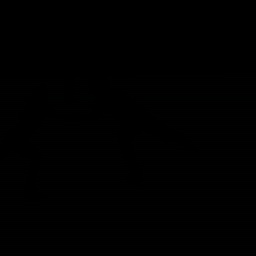

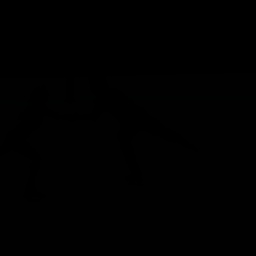

  0%|                                                                                         | 0/6067 [00:00<?, ?it/s]

Epoch 1
-------------------------------


  0%|                                                                              | 1/6067 [00:06<10:18:22,  6.12s/it]

loss: 0.0010789274238049984  [0/84930]


  0%|                                                                              | 1/6067 [00:09<16:06:21,  9.56s/it]


KeyboardInterrupt: 

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = torch.load('model.pth')
net.to(device=device)
train_net(net=net,
          epochs=1,
          batch_size=14,
          lr=1e-5,
          device=device,
          img_scale=1,
          val_percent=0.1)